In [1]:
# This section is what is contained in sv_all_run.py and used to run through the surveys

from glob import glob
import svf as svf
from echolab2.instruments import EK80
import pandas as pd
import FullWalk as fw
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# File directory for 202207
dataDir = 'E:/BB/202207_EBS/EK80/' #The data directory 
fl = fw.buildFileLists(dataDir) #Build the file lists

made 232 groups of files


In [ ]:
# File directory for 202204
dataDir = 'E:/BB/202204_Shelikof/EK80/' #The data directory 
fl = fw.buildFileLists(dataDir) #Build the file lists

In [5]:
fl[159]

['E:/BB/202207_EBS/EK80\\DY2207_EK80-D20220721-T042218.raw']

In [161]:
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
step_size = {38000:10,70000:43,120000:64,200000:128} #roughly correspond to ~.5 m using a 1ms pulse
Nfft_size = {38000:42,70000:170,120000:256,200000:512} #roughly correspond to ~2 m using a 1ms pulse

exclude_above = 5 # this can be a pyEcholab line object or an int/flt, I'm giving it 5 m as a cutoff for the whole file
exclude_below = 'xyz' # I'm going to grab the xyz files and use the line object in the file for the bottom

output_dir = 'D:/FMCW/svf/data/output/test/'
passiveLookup = pd.read_pickle('D:/FMCW/svf/passiveLookup.pkl')
s = []
for files in tqdm(fl):
    ek80 = EK80.EK80()
    ek80.read_raw(files,frequencies=38000,max_sample_count =5)
    a = (ek80.get_channel_data(38000)[38000][0].ping_time[-1]-ek80.get_channel_data(38000)[38000][0].ping_time[0])
    s.append(pd.Timedelta(a).total_seconds())

 12%|█▏        | 28/232 [04:39<26:38,  7.84s/it] Datagram 5971 (@522604484) shorter than expected length:  634936 < 2449144
Attempting to find next valid datagram...
 26%|██▋       | 61/232 [08:58<23:13,  8.15s/it]Datagram 5272 (@521145124) shorter than expected length:  1045720 < 5306264
Attempting to find next valid datagram...
100%|██████████| 232/232 [32:26<00:00,  8.39s/it]


In [44]:
dataDir  = 'E:/BB/202207_EBS/EK80/' #The data directory
from glob import glob
import os
files = sorted(glob(dataDir+'*.raw'))

print(len(np.unique([k.split('-')[1] for k in files])))

dataDir  = 'E:/BB/202204_Shelikof/EK80/' #The data directory
from glob import glob
import os
files = sorted(glob(dataDir+'*.raw'))

print(len(np.unique([k.split('-')[1] for k in files])))

35
5


In [26]:
dataDir  = 'E:/BB/202207_EBS/EK80/' #The data directory
from glob import glob
import os
files = sorted(glob(dataDir+'*.raw'))
goodFiles, noBot = [],[]
for file in files:
    if glob(dataDir+os.path.basename(file)[:-4]+'-ES38*-1.xyz'):
        goodFiles.append(file)
    else:
        noBot.append(file) # Files without xyz are passive so we'll make a separate list

In [36]:
from echolab2.instruments import EK80
pings = []
for file in noBot:
    ek80 = EK80.EK80()
    ek80.read_raw(file,frequencies=38000,max_sample_count =5)
    try:
        pings.append(ek80.get_channel_data(38000)[38000][0].n_pings)
    except:
        continue

In [37]:
np.sum(np.array(pings))

4366

In [18]:
import numpy as np
pl = passiveLookup.reset_index()
for f in pl.Freq.unique():
    print(f)
    print(10*np.log10(np.mean(10**(pl[(pl.Freq==f)&(pl.CW==False)].noiseMean/10))))
    print(10*np.log10(np.mean(10**(pl[(pl.Freq==f)&(pl.CW==True)].noiseMean/10))))

38000
-155.772558642742
-162.32325127590528
70000
-144.2452637715681
-162.52929685003141
120000
-130.1310892478558
-144.00499764414434
200000
-127.17225853858493
-143.6412815217737


In [ ]:
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
step_size = {38000:10,70000:43,120000:64,200000:128} #roughly correspond to ~.5 m using a 1ms pulse
Nfft_size = {38000:42,70000:170,120000:256,200000:512} #roughly correspond to ~2 m using a 1ms pulse

exclude_above = 5 # this can be a pyEcholab line object or an int/flt, I'm giving it 5 m as a cutoff for the whole file
exclude_below = 'xyz' # I'm going to grab the xyz files and use the line object in the file for the bottom

output_dir = 'D:/FMCW/svf/data/output/test/'
passiveLookup = pd.read_pickle('D:/FMCW/svf/passiveLookup.pkl')

for files in tqdm(fl[160:]):
    ek80 = EK80.EK80()
    ek80.read_raw(files)

    svf_results = svf.svf()
    #svt_results_fm = svf.svt()
    #svt_results_cw = svf.svt(pulse='CW')

    # Define the frequency and channel id
    for freq in frequencies:
        inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None)
        inputs.get_bottom_xyz() # Get the bottom line from the xyz files and add it to our inputs
        svf_results.calc_sample_Svf(inputs,exclude_above_line=5,exclude_below_line='xyz', Nfft=Nfft_size[freq], step=step_size[freq]) 
        svf_results.grid_Svf(inputs,interval_langth=50, layer_thickness=5)
        svf_results.get_noise(inputs)
        svf.write_grid_to_csv(svf_results,freq,output_dir=output_dir+'svf/')
        
        #svt_results_fm.grid_Svt(inputs, interval_length=50, layer_thickness=5,exclude_below_line='xyz', exclude_above_line=5,new_gain='G_fc_fm')
        #svt_results_fm.get_noise(inputs, passive_lookup=passiveLookup)
        #svf.write_grid_to_csv(svt_results_fm,freq,output_dir=output_dir+'svt/fc/')

        #svt_results_fm.grid_Svt(inputs, interval_length=50, layer_thickness=5,exclude_below_line='xyz', exclude_above_line=5,new_gain='G_fave_fm')
        #svf.write_grid_to_csv(svt_results_fm,freq,output_dir=output_dir+'svt/fave/')

        #svt_results_fm.grid_Svt(inputs, interval_length=50, layer_thickness=5,exclude_below_line='xyz', exclude_above_line=5,new_gain='G_int_fm')
        #svf.write_grid_to_csv(svt_results_fm,freq,output_dir=output_dir+'svt/int/')


        #svt_results_cw.grid_Svt(inputs, interval_length=50, layer_thickness=5,exclude_below_line='xyz', exclude_above_line=5)
        #svt_results_cw.get_noise(inputs, passive_lookup=passiveLookup)
        #svf.write_grid_to_csv(svt_results_cw,freq,output_dir=output_dir+'cw/')

In [52]:
import numpy as np
import Calculation as calc
exclude_below_line = inputs.bottom_xyz.data
exclude_above_line = np.full(len(range(0,inputs.data.n_pings)),fill_value=5)

# Note to me, maybe switch to 2 m? 42 seems to work for the 38, try the other combos for other frequenies?
a = []
Nffts = [256,512,1024,2056]

for Nfft in Nffts:
    Sv_full = []
    for ping_no in range(0,inputs.data.n_pings):
        y_rx_nu = inputs.data.complex[ping_no]
        y_rx_nu = np.array([np.array([k[0] for k in y_rx_nu]), np.array([k[1] for k in y_rx_nu]),np.array([k[2] for k in y_rx_nu]),np.array([k[3] for k in y_rx_nu])])


        if exclude_below_line is not None:
            for c in range(len(y_rx_nu)):
                y_rx_nu[c] = np.where((exclude_below_line[ping_no]<inputs.Sv_t.range), np.nan,y_rx_nu[c])
        if exclude_above_line is not None:
            for c in range(len(y_rx_nu)):
                y_rx_nu[c] = np.where((exclude_above_line[ping_no]>inputs.Sv_t.range), np.nan,y_rx_nu[c])

        # Do the pulse compression 
        y_pc_nu = calc.Calculation.calcPulseCompressedSignals(y_rx_nu, inputs.y_mf_n)
        # Take the avearage of the four channels
        y_pc_n = calc.Calculation.calcAverageSignal(y_pc_nu)
        # Convert the complex to received power
        p_rx_e_n = calc.Calculation.calcPower(y_pc_n, inputs.z_td_e, inputs.z_rx_e, inputs.N_u)
        # Compensate for the spreading loss
        y_pc_s_n = calc.Calculation.calcPulseCompSphericalSpread(y_pc_n, inputs.r_n)

        w_tilde_i, N_w, t_w, t_w_n = calc.Calculation.defHanningWindow(inputs.c, inputs.tau, inputs.dr, inputs.f_s_dec, N_w=Nfft)

        Y_pc_v_m_n, Y_mf_auto_m, Y_tilde_pc_v_m_n, svf_range = calc.Calculation.calcDFTforSv(
            y_pc_s_n, w_tilde_i, inputs.y_mf_auto_n, N_w, inputs.f_m, inputs.f_s_dec, inputs.r_n, step=10)
        
        P_rx_e_t_m_n = calc.Calculation.calcPowerFreqSv(Y_tilde_pc_v_m_n, inputs.N_u, inputs.z_rx_e, inputs.z_td_e)

        Sv_m_n = calc.Calculation.calcSvf(
                    P_rx_e_t_m_n, inputs.alpha_m, inputs.p_tx_e, inputs.lambda_m, t_w, inputs.psi_m, inputs.g_0_m, inputs.c, svf_range)
            
        Sv_full.append(Sv_m_n)
    Sv_full = np.array(Sv_full)

    a.append(Sv_full[0][300])

# Testing the Nfft variability

In [96]:
import os
import numpy as np
import pandas as pd

def makeArray(text):
    return np.fromstring(text,sep=';')

freq=38000
output_dir = 'D:/FMCW/svf/data/output/test/svf/orig/'

file_dates = np.unique([file.split('-')[0] for file in [os.path.basename(file) for file in glob(output_dir+'*'+str(int(freq/1000))+'*.csv')]])

all_data = []
for date in sorted(file_dates):
    output_files = glob(output_dir+date+'*'+str(int(freq/1000))+'*.csv')
    cur_date = [pd.read_csv(file) for file in output_files]
    cur_date = pd.concat(cur_date)
    cur_date['fileset'] = date
    cur_date['frequency'] = cur_date['frequency'].apply(makeArray)
    cur_date['mean_Sv'] = cur_date['mean_Sv'].apply(makeArray)
    cur_date['SNR'] = cur_date['SNR'].apply(makeArray)
    cur_date['mean_Sv_ave'] = cur_date['mean_Sv'].apply(svf.pMean)
    cur_date['SNR_ave'] = cur_date['SNR'].apply(svf.pMean)
    #cur_date.drop(['mean_Sv','SNR','frequency'],axis=1,inplace=True)
    all_data.append(cur_date)
all_data = pd.concat(all_data)

all_data['time_start'] = pd.to_datetime(all_data['time_start'])
all_data['time_end'] = pd.to_datetime(all_data['time_end'])
all_data['nasc'] = (10**(all_data.mean_Sv_ave/10))*(all_data.layer_end-all_data.layer_start)*4*np.pi*(1852**2)

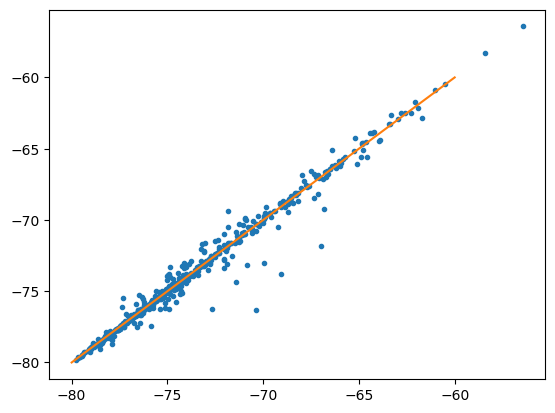

In [102]:
a = all_data_o.merge(all_data_n,on=['time_start','time_end','layer_start','layer_end','fileset'])
plt.plot(a.mean_Sv_ave_x,a.mean_Sv_ave_y,'.')
plt.plot([-80,-60],[-80,-60])

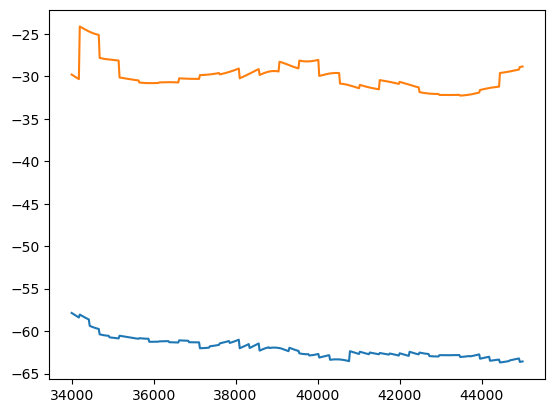

In [32]:
i = 1
import matplotlib.pyplot as plt
plt.plot(all_data.iloc[i].frequency,all_data.iloc[i].mean_Sv)
plt.plot(.iloc[i].frequency,all_data_new.iloc[i].mean_Sv)

In [274]:
f_s, cal_s, rat_s = [], [], []
for i in range(5000):
    for f in [38000, 70000,120000]:
        for cal in ['G_fave_fm']:
            Gcw = 10*np.log10(np.nanmean(10**(dfCal[(dfCal.f==f/1000)&(dfCal.G_cw.notnull())]['G_cw']/10)))


            Gfm = 10*np.log10(np.nanmean(10**(dfCal[(dfCal.f==f/1000)&(dfCal[cal].notnull())][cal]/10)))


            r = np.random.randint(0, len(dfCal[(dfCal.f==f/1000)&(dfCal.G_cw.notnull())]['G_cw']))
            rGcw = dfCal[(dfCal.f==f/1000)&(dfCal.G_cw.notnull())]['G_cw'].iloc[r]#+dfCal[(dfCal.f==f/1000)&(dfCal.G_cw.notnull())]['sACorr'].iloc[r]

            r = np.random.randint(0, len(dfCal[(dfCal.f==f/1000)&(dfCal[cal].notnull())][cal]))
            rGfm = dfCal[(dfCal.f==f/1000)&(dfCal[cal].notnull())][cal].iloc[r]

            ratCW = (10**(2*(rGcw-Gcw)/10))
            ratFM = (10**(2*(rGfm-Gfm)/10))
            ratG = ratFM/ratCW

            rC = allMerge[allMerge.channel_0==f].sample(n=len(allMerge[allMerge.channel_0==f]),replace=True)
            ratSA = rC['nasc_1']/rC['nasc_0']
            ratSA = np.nanmean(ratSA)

            f_s.append(f)
            cal_s.append(cal)
            rat_s.append(ratG*ratSA)

ratio = pd.DataFrame({'f':f_s,'calType':cal_s,'r':rat_s})

# Process the outputs

I'm using Dask for the read in which speeds up the initial dataframe setup

In [27]:
# Todo: keep reference to last ping time in the file

In [1]:
import dask.dataframe as dd
from dask.distributed import Client

import dask
import numpy as np
import svf as svf

# I'm lazy so I wanted a function for subsetting the smaller bandwidth section of the data. I need to turn this into a lookup with the real values
def sv_bw(g,f,z):
    return svf.pMean(g[np.where(np.abs(f-z)<(1000/2))])

In [2]:
client = Client(n_workers=4, threads_per_worker=4)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52056,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.70 GiB
Comm: tcp://127.0.0.1:52097,Total threads: 4
Dashboard: http://127.0.0.1:52098/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:52060,


In [4]:
output_dir = 'D:/FMCW/svf/data/output/' # This is the upper level directory where the output files are stored
outputs_svt = ['cw','svt/fave','svt/int','svt/fc'] # There are a series of subfolders organized by gain
bw = .025 # again this needs to be replaced but is used to feed the bw function above

In [16]:
258*5

1290

In [15]:
ddf_svf[~ddf_svf.mean_Sv_f.isna()].sort_values('layer',ascending=False)

,index,channel,interval,layer,time_start,layer_thickness,SNR_f,mean_Sv_f,mean_Sv_f_bw,file_name
257,257,120000,1,258,2022-06-11 09:31:15.267,5,11.317039,24.555514,17.869028,D20220611-T093112_120.csv
517,517,120000,2,258,2022-06-11 09:51:32.462,5,11.731799,24.474950,21.949699,D20220611-T093112_120.csv
516,516,120000,2,257,2022-06-11 09:51:32.462,5,11.973928,23.923412,14.372479,D20220611-T093112_120.csv
256,256,120000,1,257,2022-06-11 09:31:15.267,5,10.795964,23.443836,17.473552,D20220611-T093112_120.csv
515,515,120000,2,256,2022-06-11 09:51:32.462,5,10.452887,22.548324,14.547945,D20220611-T093112_120.csv
...,...,...,...,...,...,...,...,...,...,...
641,641,38000,9,2,2022-08-04 16:33:30.059,5,48.366995,-74.542152,-73.520065,D20220804-T160208_38.csv
1,1,200000,1,2,2022-06-17 05:25:21.609,5,31.459808,-79.856372,-80.516390,D20220617-T052518_200.csv
301,301,70000,16,2,2022-07-26 11:47:15.602,5,57.594252,-62.102987,-61.860809,D20220726-T112912_70.csv
151,151,120000,4,2,2022-06-28 08:38:51.740,5,59.770447,-66.378858,-66.107463,D20220628-T083103_120.csv


In [5]:
ddf = dd.read_csv(output_dir+'svf/*.csv',include_path_column="file_path") # Read in svf output data
ddf = ddf.reset_index().compute()
ddf['frequency'] = ddf['frequency'].map(lambda x: np.array([float(i) for i in x.split(';')])) # convert strings to vectors
ddf['mean_Sv'] = ddf['mean_Sv'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['SNR'] = ddf['SNR'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['SNR_f'] = ddf['SNR'].map(svf.pMean) # Get the average SNR (this is the lazy way to do this for now)
ddf['mean_Sv_f'] = ddf['mean_Sv'].map(svf.pMean) # Get the average Sv(f)
ddf['time_start'] = ddf['time_start'].astype("M8[us]") # fix the time stamps for later
ddf['mean_Sv_f_bw'] = ddf.apply(lambda x: sv_bw(x.mean_Sv,x.frequency,x.channel),axis=1) # Get the mean for the subset within a certain bandwidth around the nominal frequency
ddf['file_name'] = ddf.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1]) # insert the file name just so I can hold it fo reference
ddf.drop(['frequency','ping_start','ping_end','layer_start','time_end','layer_end','SNR','mean_Sv','lat_start','lon_start','file_path'],axis=1,inplace=True) # clear out the unused data
ddf_svf = ddf # give it a name to id it

d:\FMCW\svf\svf.py:457: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))
d:\FMCW\svf\svf.py:457: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))
d:\FMCW\svf\svf.py:457: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))


In [6]:
# Now build the match dataset for cw, it's all roughlly similar to above
output = 'cw'
ddf_cw = dd.read_csv(output_dir+output+'/*.csv',include_path_column="file_path")
ddf_cw = ddf_cw.reset_index().compute()
ddf_cw['time_start'] = ddf_cw['time_start'].astype("M8[us]")
ddf_cw['file_name'] = ddf_cw.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1])
ddf_cw.drop(['frequency','ping_start','ping_end','layer_start','time_end','layer_end','file_path','index'],axis=1,inplace=True)
ddf_cw['type'] = output
ddf_cw = ddf_cw.rename(columns={'mean_Sv':'mean_Sv_cw','SNR':'SNR_cw'}) # rename the columns for comparison when merged

In [7]:
ddf_merge_t = ddf_cw # setup what will be our big dataframe of all the sv(t), including cw

outputs_svt = ['svt/fave','svt/int','svt/fc'] # I separated this out for naming for now but this should be combined with the above cell
for output in outputs_svt:
    ddf_cur = dd.read_csv(output_dir+output+'/*.csv',include_path_column="file_path")
    ddf_cur = ddf_cur.reset_index().compute()
    ddf_cur['time_start'] = ddf_cur['time_start'].astype("M8[us]")
    ddf_cur['file_name'] = ddf_cur.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1])
    ddf_cur.drop(['frequency','ping_start','ping_end','layer_start','time_end','layer_end','lat_start','lon_start','file_path','index','layer_thickness'],axis=1,inplace=True)
    #ddf_cur['type'] = output.split('/')[1]
    ddf_cur = ddf_cur.rename(columns={c: c+'_'+output.split('/')[1] for c in ddf_cur.columns if c not in ['file_name','channel','interval', 'layer']})
    ddf_merge_t = ddf_merge_t.merge(ddf_cur,how='outer',on=['file_name','channel','interval','layer']) # merge everything on the filename, frequency, interval, and layer

In [8]:
# Now thw svf and svt dataframes have to be combined
ddf_merge_t = ddf_merge_t.drop(ddf_merge_t.filter(regex='layer_').columns, axis=1).drop(ddf_merge_t.filter(regex='time_start_').columns, axis=1).drop(ddf_merge_t.filter(regex='type').columns, axis=1)
ddf_merge_all = ddf_merge_t.merge(ddf_svf,how='outer',on=['file_name','channel','interval','layer'],suffixes=('','_f')).dropna()

# Set some sort of SNR threshold and check against all the SNR versions
snr = 10
ddf_merge_all_snr = ddf_merge_all[(ddf_merge_all.SNR_cw>snr)&(ddf_merge_all.SNR_fave>snr)&(ddf_merge_all.SNR_fc>snr)&(ddf_merge_all.SNR_f>snr)&(ddf_merge_all.SNR_int>snr)]
ddf_merge_all_snr = ddf_merge_all_snr[~np.isinf(ddf_merge_all_snr.mean_Sv_f)]

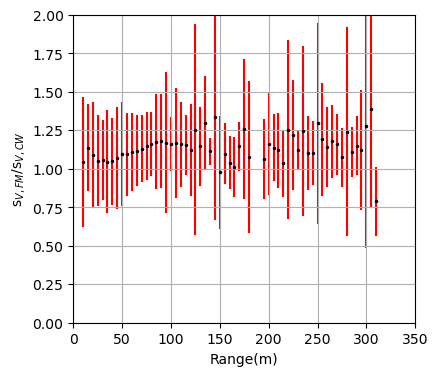

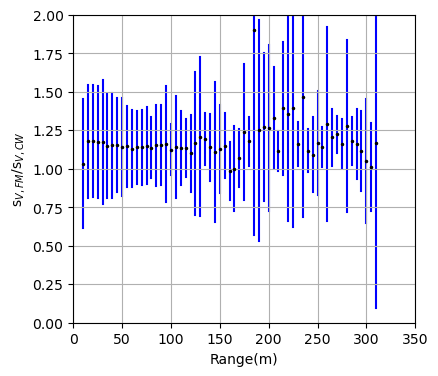

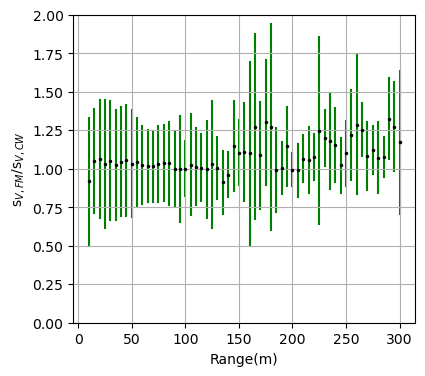

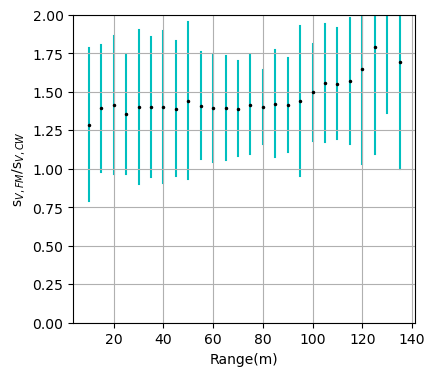

In [9]:
import matplotlib.pyplot as plt

c = ddf_merge_all_snr[~((ddf_merge_all_snr.time_start.dt.month==7)&(ddf_merge_all_snr.time_start.dt.day==3)&(ddf_merge_all_snr.time_start.dt.hour<10))&~((ddf_merge_all_snr.time_start.dt.month==6)&(ddf_merge_all_snr.time_start.dt.day==16))]

cs = {38000:'r', 70000:'b', 120000:'g', 200000:'c'}
for f in [38000,70000,120000,200000]:
    fig = plt.figure(figsize=(15,4))
    ct=1
    plt.subplot(1,3,ct)
    a = c[(c.channel==f)&(c.mean_Sv_cw>-70)&(c.mean_Sv_f>-70)&(c.mean_Sv_fave>-70)&(c.mean_Sv_fc>-70)&(c.mean_Sv_int>-70)]
    for l in a.layer.unique():
        
        curLayer = a[a.layer==l]
        rat = 10**(curLayer.mean_Sv_f/10)/10**(curLayer.mean_Sv_cw/10)
        rat[rat>5] = np.nan
        if len(rat)<5:
            continue
        plt.plot(l*5,np.mean(rat),'.',color='k',markersize=3)
        plt.plot([l*5,l*5],[np.mean(rat)-np.std(rat),np.mean(rat)+np.std(rat)],'-',color=cs[f],zorder=0)
    
    plt.grid()
    plt.ylim([0,2])
    if f == 38000:
        plt.xlim([0,350])
    elif f == 70000:
        plt.xlim([0,350])
    if ct == 1:
        plt.ylabel('s$_{V,FM}$/s$_{V,CW}$')
    plt.xlabel('Range(m)')
    ct+=1


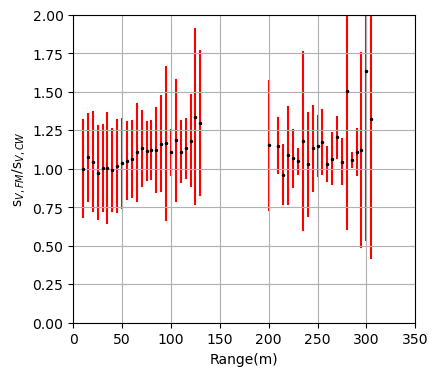

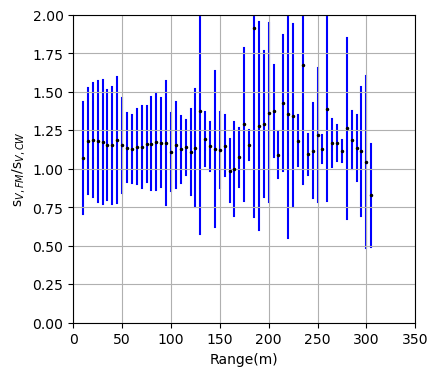

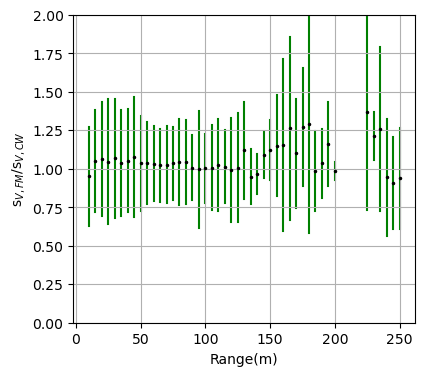

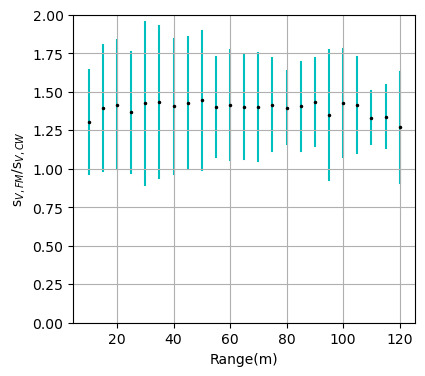

In [22]:
import matplotlib.pyplot as plt

c = ddf_merge_all_snr[~((ddf_merge_all_snr.time_start.dt.month==7)&(ddf_merge_all_snr.time_start.dt.day==3)&(ddf_merge_all_snr.time_start.dt.hour<10))&~((ddf_merge_all_snr.time_start.dt.month==6)&(ddf_merge_all_snr.time_start.dt.day==16))]

cs = {38000:'r', 70000:'b', 120000:'g', 200000:'c'}
for f in [38000,70000,120000,200000]:
    fig = plt.figure(figsize=(15,4))
    ct=1
    plt.subplot(1,3,ct)
    a = c[(c.channel==f)&(c.mean_Sv_cw>-70)&(c.mean_Sv_f>-70)&(c.mean_Sv_fave>-70)&(c.mean_Sv_fc>-70)&(c.mean_Sv_int>-70)]
    for l in a.layer.unique():
        
        curLayer = a[a.layer==l]
        rat = 10**(curLayer.mean_Sv_f/10)/10**(curLayer.mean_Sv_cw/10)
        rat[rat>5] = np.nan
        if len(rat)<5:
            continue
        plt.plot(l*5,np.mean(rat),'.',color='k',markersize=3)
        plt.plot([l*5,l*5],[np.mean(rat)-np.std(rat),np.mean(rat)+np.std(rat)],'-',color=cs[f],zorder=0)
    
    plt.grid()
    plt.ylim([0,2])
    if f == 38000:
        plt.xlim([0,350])
    elif f == 70000:
        plt.xlim([0,350])
    if ct == 1:
        plt.ylabel('s$_{V,FM}$/s$_{V,CW}$')
    plt.xlabel('Range(m)')
    ct+=1


In [10]:
'''
Current problems 
- Need to add an extra gains pick, and confirm that i didn't already add the psi into the actual calibration values
'''
ddf_merge_all_snr[ddf_merge_all_snr.channel==70000].sort_values('mean_Sv_fave',ascending=False).head(10)

,channel,interval,layer,time_start,lat_start,lon_start,mean_Sv_cw,SNR_cw,file_name,mean_Sv_fave,...,mean_Sv_int,SNR_int,mean_Sv_fc,SNR_fc,index,time_start_f,layer_thickness,SNR_f,mean_Sv_f,mean_Sv_f_bw
632162,70000,1,47,2022-08-04 16:33:54.002,54.099006,-166.484953,-22.197725,86.443301,D20220804-T163350_70.csv,-18.398626,...,-18.409558,78.931280,-17.902526,79.438311,46,2022-08-04 16:33:54.570,5,78.163749,-17.507876,-17.287334
632363,70000,2,48,2022-08-04 16:37:47.389,54.099328,-166.486383,-26.536201,81.720250,D20220804-T163350_70.csv,-18.927782,...,-18.938714,78.017548,-18.431682,78.524580,247,2022-08-04 16:37:47.956,5,77.342367,-17.947204,-17.937263
172523,70000,3,92,2022-06-16 15:03:22.879,53.962274,-167.076984,-19.448131,71.668175,D20220616-T143520_70.csv,-18.992535,...,-19.003467,56.569668,-18.496435,57.076700,451,2022-06-16 15:03:24.818,5,65.156983,-18.452161,-17.687864
632364,70000,2,49,2022-08-04 16:37:47.389,54.099328,-166.486383,-14.677606,93.198120,D20220804-T163350_70.csv,-20.246076,...,-20.257008,76.318529,-19.749976,76.825561,248,2022-08-04 16:37:47.956,5,75.438911,-19.416570,-19.541288
643562,70000,1,47,2022-08-04 21:03:23.195,54.099490,-166.469896,-18.757023,89.884003,D20220804-T210320_70.csv,-20.418846,...,-20.429778,76.911059,-19.922747,77.418091,46,2022-08-04 21:03:24.594,5,81.686585,-19.417680,-18.789433
632163,70000,1,48,2022-08-04 16:33:54.002,54.099006,-166.484953,-18.683765,89.572685,D20220804-T163350_70.csv,-20.660799,...,-20.671731,76.284531,-20.164699,76.791563,47,2022-08-04 16:33:54.570,5,75.408895,-19.921304,-19.990262
642762,70000,4,47,2022-08-04 21:01:02.060,54.099822,-166.472257,-21.037740,87.603286,D20220804-T203140_70.csv,-20.883505,...,-20.894436,76.446401,-20.387405,76.953433,646,2022-08-04 21:01:03.450,5,82.182270,-19.972291,-19.371109
642763,70000,4,48,2022-08-04 21:01:02.060,54.099822,-166.472257,-20.814336,87.442115,D20220804-T203140_70.csv,-21.008541,...,-21.019473,75.936789,-20.512442,76.443820,647,2022-08-04 21:01:03.450,5,81.539399,-20.027986,-19.360842
632764,70000,4,49,2022-08-04 16:45:34.580,54.100222,-166.489544,-82.092374,25.783352,D20220804-T163350_70.csv,-21.066185,...,-21.077116,75.498421,-20.570085,76.005452,648,2022-08-04 16:45:35.148,5,74.782049,-20.047071,-20.097174
643561,70000,1,46,2022-08-04 21:03:23.195,54.099490,-166.469896,-22.016097,87.013522,D20220804-T210320_70.csv,-21.682020,...,-21.692951,76.036479,-21.185920,76.543511,45,2022-08-04 21:03:24.594,5,81.047031,-20.572671,-22.170923


In [36]:
'''
Current problems 
- Need to add an extra gains pick, and confirm that i didn't already add the psi into the actual calibration values
'''
ddf_merge_all_snr[ddf_merge_all_snr.channel==70000].sort_values('mean_Sv_fave',ascending=False).head(10)

,channel,interval,layer,time_start,lat_start,lon_start,mean_Sv_cw,SNR_cw,file_name,mean_Sv_fave,...,mean_Sv_int,SNR_int,mean_Sv_fc,SNR_fc,index,time_start_f,layer_thickness,SNR_f,mean_Sv_f,mean_Sv_f_bw
632162,70000,1,47,2022-08-04 16:33:54.002,54.099006,-166.484953,-22.197725,86.443301,D20220804-T163350_70.csv,-18.398626,...,-18.409558,78.931280,-17.902526,79.438311,46,2022-08-04 16:33:54.570,5,78.163749,-17.507876,-17.287334
632363,70000,2,48,2022-08-04 16:37:47.389,54.099328,-166.486383,-26.536201,81.720250,D20220804-T163350_70.csv,-18.927782,...,-18.938714,78.017548,-18.431682,78.524580,247,2022-08-04 16:37:47.956,5,77.342367,-17.947204,-17.937263
172523,70000,3,92,2022-06-16 15:03:22.879,53.962274,-167.076984,-19.448131,71.668175,D20220616-T143520_70.csv,-18.992535,...,-19.003467,56.569668,-18.496435,57.076700,451,2022-06-16 15:03:24.818,5,65.156983,-18.452161,-17.687864
632364,70000,2,49,2022-08-04 16:37:47.389,54.099328,-166.486383,-14.677606,93.198120,D20220804-T163350_70.csv,-20.246076,...,-20.257008,76.318529,-19.749976,76.825561,248,2022-08-04 16:37:47.956,5,75.438911,-19.416570,-19.541288
643562,70000,1,47,2022-08-04 21:03:23.195,54.099490,-166.469896,-18.757023,89.884003,D20220804-T210320_70.csv,-20.418846,...,-20.429778,76.911059,-19.922747,77.418091,46,2022-08-04 21:03:24.594,5,81.686585,-19.417680,-18.789433
632163,70000,1,48,2022-08-04 16:33:54.002,54.099006,-166.484953,-18.683765,89.572685,D20220804-T163350_70.csv,-20.660799,...,-20.671731,76.284531,-20.164699,76.791563,47,2022-08-04 16:33:54.570,5,75.408895,-19.921304,-19.990262
642762,70000,4,47,2022-08-04 21:01:02.060,54.099822,-166.472257,-21.037740,87.603286,D20220804-T203140_70.csv,-20.883505,...,-20.894436,76.446401,-20.387405,76.953433,646,2022-08-04 21:01:03.450,5,82.182270,-19.972291,-19.371109
642763,70000,4,48,2022-08-04 21:01:02.060,54.099822,-166.472257,-20.814336,87.442115,D20220804-T203140_70.csv,-21.008541,...,-21.019473,75.936789,-20.512442,76.443820,647,2022-08-04 21:01:03.450,5,81.539399,-20.027986,-19.360842
632764,70000,4,49,2022-08-04 16:45:34.580,54.100222,-166.489544,-82.092374,25.783352,D20220804-T163350_70.csv,-21.066185,...,-21.077116,75.498421,-20.570085,76.005452,648,2022-08-04 16:45:35.148,5,74.782049,-20.047071,-20.097174
643561,70000,1,46,2022-08-04 21:03:23.195,54.099490,-166.469896,-22.016097,87.013522,D20220804-T210320_70.csv,-21.682020,...,-21.692951,76.036479,-21.185920,76.543511,45,2022-08-04 21:03:24.594,5,81.047031,-20.572671,-22.170923


In [45]:
(10**(-40/10))*5*4*np.pi*(1852**2)

21550.722417836492

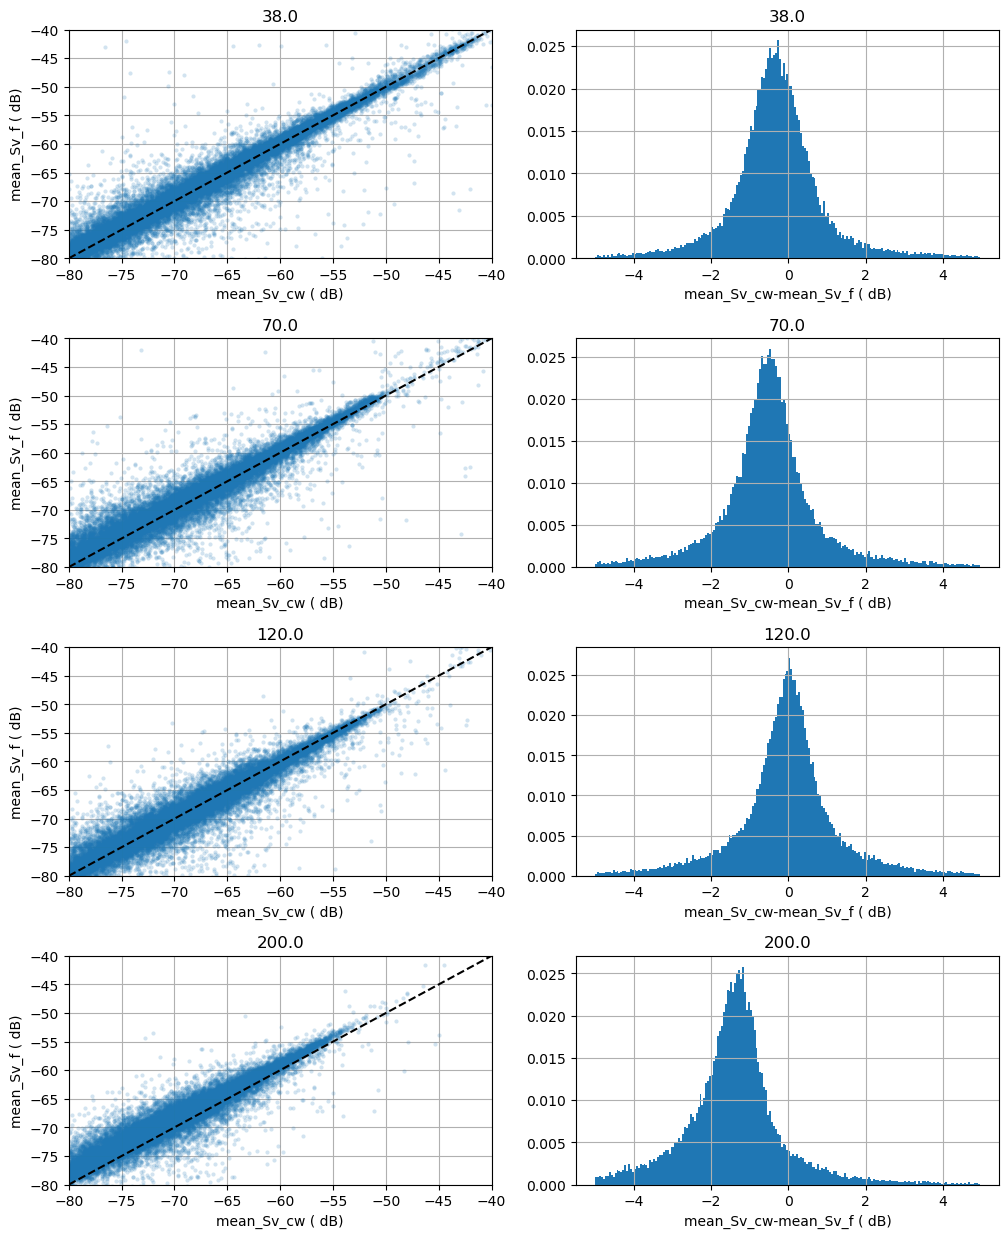

In [50]:
import matplotlib.pyplot as plt 
spct = 1
min = -80
df = ddf_merge_all_snr[ddf_merge_all_snr.mean_Sv_cw>min]
x_sv = 'mean_Sv_cw'
y_sv = 'mean_Sv_f'

fig = plt.figure(figsize=(12,15))
for channel in sorted(df.channel.unique()):
    plt.subplot(4,2,spct)
    plt.plot(df[df.channel==channel][x_sv],df[df.channel==channel][y_sv],'.',alpha=0.2,markeredgecolor='none')
    plt.grid()
    plt.axis([min,-40,min,-40])
    plt.title(channel/1000)
    plt.plot([min,-40],[min,-40],'--k')
    plt.ylabel(y_sv+' ( dB)')
    plt.xlabel(x_sv+' ( dB)')
    spct += 1
    plt.subplot(4,2,spct)
    plt.hist(df[df.channel==channel][x_sv]-df[df.channel==channel][y_sv],bins=np.arange(-5,5,.05),
             weights=np.ones_like(df[df.channel==channel][x_sv]-df[df.channel==channel][y_sv]) / len(df[df.channel==channel][x_sv]-df[df.channel==channel][y_sv]))
    plt.grid()
    plt.xlabel(x_sv+'-'+y_sv+' ( dB)')
    plt.title(channel/1000)
    
    
    
    spct += 1

plt.subplots_adjust(hspace=0.35,wspace=0.2)

In [12]:
import gains
gain = gains.gains()

d:\FMCW\svf\gains.py:130: RuntimeWarning: Mean of empty slice
  df.loc[(df.cruise==cruise)&(df.leg==leg)&(df.f==f),'G_int_fm'] = 10*np.log10(np.nanmean(10**(curG/10)))


In [18]:
ddf_hold = ddf_merge_all_snr[ddf_merge_all_snr.mean_Sv_cw>-70]
ddf_hold = ddf_hold[['channel','time_start']].merge(ddf_hold[ddf_hold.columns[ddf_hold.columns.map(lambda x: x.startswith("mean_Sv"))]],left_index=True, right_index=True)
ddf_hold = ddf_hold[ddf_hold.mean_Sv_fave<-10]
ddf_hold = ddf_hold.set_index('time_start')
ddf_hold = ddf_hold.groupby(['channel']).resample('.25H').apply(svf.pMean).drop(columns=['channel']).reset_index()
ddf_hold = ddf_hold[~ddf_hold.mean_Sv_cw.isna()]

d:\FMCW\svf\svf.py:457: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))


In [19]:
import pandas as pd
calRef = {'mean_Sv_fave':'G_fave_fm','mean_Sv_int':'G_int_fm','mean_Sv_fc':'G_fc_fm','mean_Sv_f':'G_fave_fm','mean_Sv_f_bw':'G_fave_fm'}

f_s, cal_s, rat_s,rat_g,rat_sa = [], [], [],[],[]
for i in range(5000):
    for f in [38000,70000,120000,200000]:
        for cal in ['mean_Sv_fave','mean_Sv_int','mean_Sv_fc','mean_Sv_f','mean_Sv_f_bw']:
            Gcw = 10*np.log10(np.nanmean(10**(gain.df[(gain.df.f==f/1000)]['G_cw']/10))) # get the mean CW cal

            Gfm = 10*np.log10(np.nanmean(10**(gain.df[(gain.df.f==f/1000)][calRef[cal]]/10)))# get the mean FM cal for our current cal type

            r = np.random.randint(0, len(gain.df[(gain.df.f==f/1000)]['G_cw'])) # randomly draw a number between 1 and the number of cw cals we have
            rGcw = gain.df[(gain.df.f==f/1000)]['G_cw'].iloc[r] # get the random CW cal 

            r = np.random.randint(0, len(gain.df[(gain.df.f==f/1000)][calRef[cal]])) # randomly draw a number between 1 and the number of fm cals we have
            rGfm = gain.df[(gain.df.f==f/1000)][calRef[cal]].iloc[r] # get the random FM cal for our current cal type

            ratCW = (10**(2*(rGcw-Gcw)/10)) # calculate the ratio of the current CW cal to the mean CW cal
            ratFM = (10**(2*(rGfm-Gfm)/10)) # calculate the ratio of the current FM cal to the mean FM cal
            ratG = ratFM/ratCW # Get our 'gain' ratio
            

            rC = ddf_hold[(ddf_hold.channel==f)].sample(n=len(ddf_hold[(ddf_hold.channel==f)]),replace=True)
            
            cwsa = (10**((rC['mean_Sv_cw'])/10))*5*4*np.pi*(1852**2)
            fmsa = (10**((rC[cal])/10))*5*4*np.pi*(1852**2)
            
            ratSA = fmsa/cwsa # compute cell-by-cell ratio of the current cal type to the CW cal type
            ratSA2 = 10**(np.nanmean(np.log10(ratSA*ratG))) # compute ratio average and apply gain difference

            f_s.append(f)
            cal_s.append(cal)
            rat_s.append(ratSA2)
            rat_sa.append(10**(np.nanmean(np.log10(ratSA))))
            rat_g.append(ratG)

ratios = pd.DataFrame({'f':f_s,'calType':cal_s,'r':rat_s,'r_sa':rat_sa,'rg':rat_g})

Text(0.5, 0, 'Final bootstrap sA ratio')

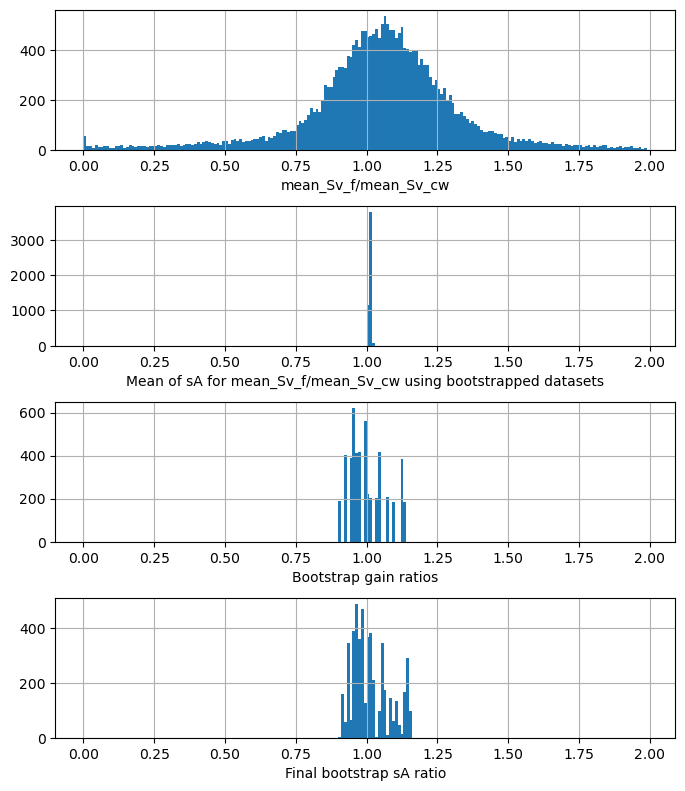

In [27]:
plt.figure(figsize=(8,12))

sv1 = 'mean_Sv_f'
sv2 = 'mean_Sv_cw'
f=38000

plt.subplot(5,1,1)
plt.hist((10**(ddf_hold[ddf_hold.channel==f][sv1]/10))/(10**(ddf_hold[ddf_hold.channel==f][sv2]/10)),bins=np.arange(0,2,.01));
plt.xlabel(sv1+'/'+sv2)
plt.grid()

plt.subplot(5,1,2)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].r_sa,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Mean of sA for '+sv1+'/'+sv2+' using bootstrapped datasets')

plt.subplot(5,1,3)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].rg,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Bootstrap gain ratios')

plt.subplot(5,1,4)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].r,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Final bootstrap sA ratio')

Text(0.5, 0, 'Final bootstrap sA ratio')

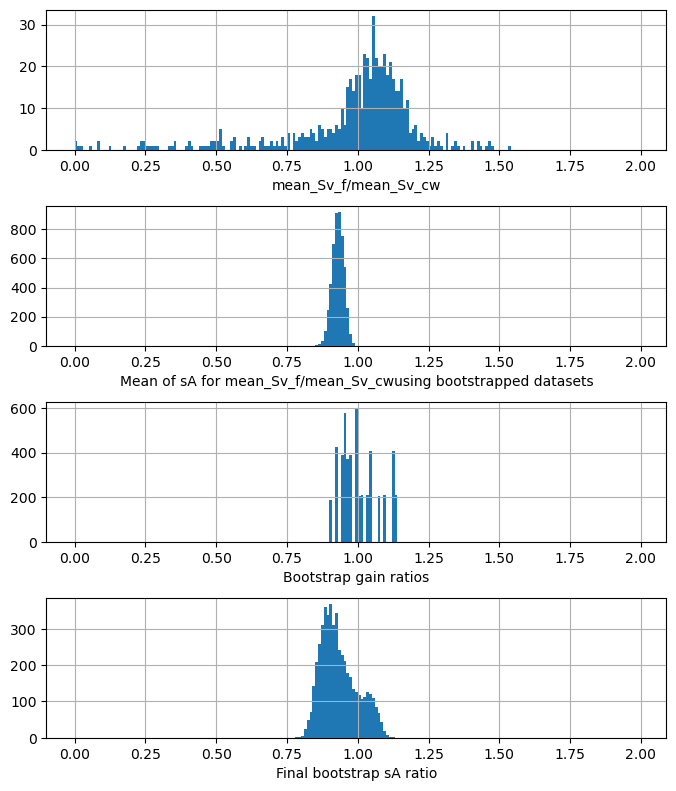

In [17]:
plt.figure(figsize=(8,12))

sv1 = 'mean_Sv_f'
sv2 = 'mean_Sv_cw'
f=38000

plt.subplot(5,1,1)
plt.hist((10**(ddf_hold[ddf_hold.channel==f][sv1]/10))/(10**(ddf_hold[ddf_hold.channel==f][sv2]/10)),bins=np.arange(0,2,.01));
plt.xlabel(sv1+'/'+sv2)
plt.grid()

plt.subplot(5,1,2)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].r_sa,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Mean of sA for '+sv1+'/'+sv2+'using bootstrapped datasets')

plt.subplot(5,1,3)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].rg,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Bootstrap gain ratios')

plt.subplot(5,1,4)
plt.hist(ratios[(ratios.f==f)&(ratios.calType==sv1)].r,bins=np.arange(0,2,.01));
plt.grid()
plt.subplots_adjust(hspace=0.4)
plt.xlabel('Final bootstrap sA ratio')

In [40]:
ratios[(ratios.f==200000)&(ratios.calType=='mean_Sv_f')]

,f,calType,r,r_sa,rg
18,200000,mean_Sv_f,inf,inf,0.951510
38,200000,mean_Sv_f,0.995056,1.263965,0.787250
58,200000,mean_Sv_f,1.038957,1.262410,0.822994
78,200000,mean_Sv_f,1.222416,1.235278,0.989588
98,200000,mean_Sv_f,1.307529,1.263899,1.034520
...,...,...,...,...,...
99918,200000,mean_Sv_f,inf,inf,1.129845
99938,200000,mean_Sv_f,inf,inf,1.224449
99958,200000,mean_Sv_f,0.933333,1.213948,0.768841
99978,200000,mean_Sv_f,inf,inf,0.951510


Text(0.5, 0, 'Frequency (kHz)')

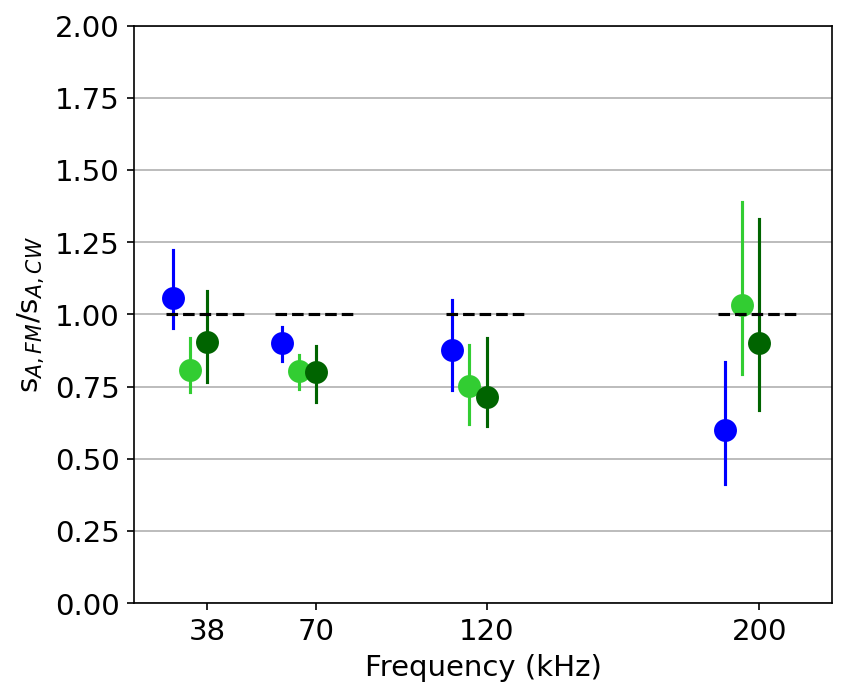

In [46]:
# 15 min 
plt.figure(figsize=(6,5),dpi=150)
plt.rcParams.update({'font.size': 14})
colors = {'mean_Sv_fc':'b','mean_Sv_fave':'limegreen','mean_Sv_int':'darkgreen','mean_Sv_f':'violet','mean_Sv_f_bw':'darkviolet'}
alphas = {'mean_Sv_fc':1,'mean_Sv_fave':1,'mean_Sv_int':1,'mean_Sv_f':1,'mean_Sv_f_bw':1}
frequencies = [38000,70000,120000,200000]
for f in frequencies:
    fp =f 
    for cal in ['mean_Sv_fc','mean_Sv_fave','mean_Sv_int']:#,'mean_Sv_f']:#,'mean_Sv_f_bw']:
        plt.plot(fp-10000,10**(np.nanmean(np.log10(ratios[(ratios.f==f)&(ratios.calType==cal)].r))),'.',color=colors[cal],alpha=alphas[cal],markersize=20)
        #plt.plot(fp-10000,np.nanmedian(ratios[(ratios.f==f)&(ratios.calType==cal)].r),'x',color=colors[cal],markersize=20,label='_nolegend_')
        plt.plot([fp-10000,fp-10000],[np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,2.5), np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,97.5)],color=colors[cal],markersize=20,label='_nolegend_')
        fp+=5000
    plt.hlines(1,f-12000,f+12000,'k',linestyle='--')
plt.ylim([0,2])
plt.xticks(frequencies,labels = [str(int(f/1000)) for f in frequencies])
plt.grid(axis='y')                                              
#plt.legend(['$g_{fc}$',r'$\bar{g_{f}}$','$g_{Int}$','S$_{V}$(f)','S$_{V}$(f$_{CW}$)'],ncol=2)
plt.ylabel('s$_{A,FM}$/s$_{A,CW}$')
plt.xlabel('Frequency (kHz)')


In [ ]:
# 15 min 
plt.figure(figsize=(6,5),dpi=150)
plt.rcParams.update({'font.size': 14})
colors = {'mean_Sv_fc':'b','mean_Sv_fave':'limegreen','mean_Sv_int':'darkgreen','mean_Sv_f':'violet','mean_Sv_f_bw':'darkviolet'}
frequencies = [38000,70000,120000,200000]
for f in frequencies:
    fp =f 
    for cal in ['mean_Sv_fc','mean_Sv_fave','mean_Sv_int','mean_Sv_f','mean_Sv_f_bw']:
        plt.plot(fp-10000,10**(np.nanmean(np.log10(ratios[(ratios.f==f)&(ratios.calType==cal)].r))),'.',color=colors[cal],markersize=20)
        #plt.plot(fp-10000,np.nanmedian(ratios[(ratios.f==f)&(ratios.calType==cal)].r),'x',color=colors[cal],markersize=20,label='_nolegend_')
        plt.plot([fp-10000,fp-10000],[np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,2.5), np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,97.5)],color=colors[cal],markersize=20,label='_nolegend_')
        fp+=5000
    plt.hlines(1,f-12000,f+12000,'k',linestyle='--')
plt.ylim([0,2])
plt.xticks(frequencies,labels = [str(int(f/1000)) for f in frequencies])
plt.grid(axis='y')                                              
plt.legend(['$g_{fc}$',r'$\bar{g_{f}}$','$g_{Int}$','S$_{V}$(f)','S$_{V}$(f$_{Narrow}$)'],ncol=2)
plt.ylabel('s$_{A,FM}$/s$_{A,CW}$')
plt.xlabel('Frequency (kHz)')


Text(0.5, 0, 'Frequency (kHz)')

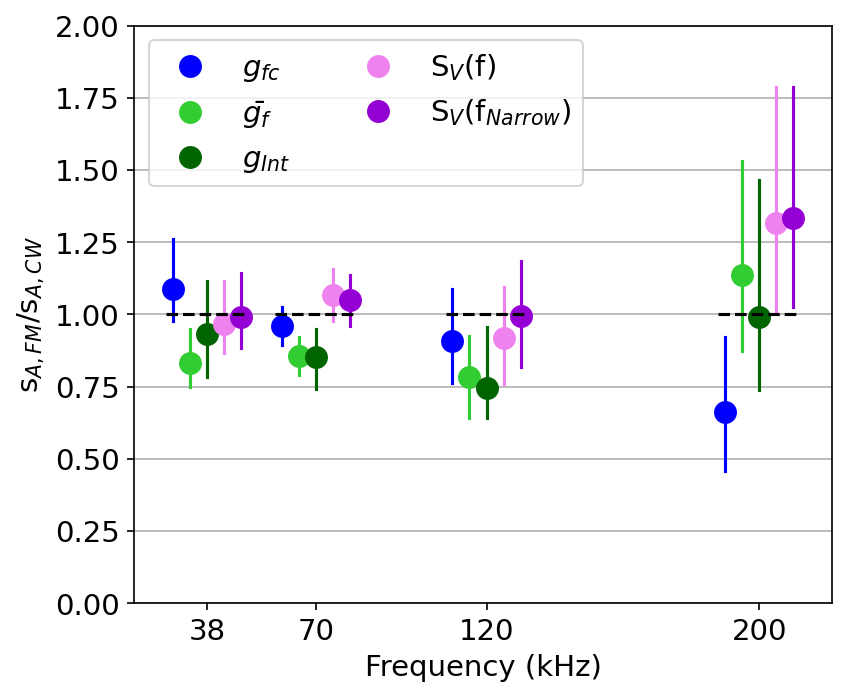

In [17]:
# 15 min 
plt.figure(figsize=(6,5),dpi=150)
plt.rcParams.update({'font.size': 14})
colors = {'mean_Sv_fc':'b','mean_Sv_fave':'limegreen','mean_Sv_int':'darkgreen','mean_Sv_f':'violet','mean_Sv_f_bw':'darkviolet'}
frequencies = [38000,70000,120000,200000]
for f in frequencies:
    fp =f 
    for cal in ['mean_Sv_fc','mean_Sv_fave','mean_Sv_int','mean_Sv_f','mean_Sv_f_bw']:
        plt.plot(fp-10000,10**(np.nanmean(np.log10(ratios[(ratios.f==f)&(ratios.calType==cal)].r))),'.',color=colors[cal],markersize=20)
        #plt.plot(fp-10000,np.nanmedian(ratios[(ratios.f==f)&(ratios.calType==cal)].r),'x',color=colors[cal],markersize=20,label='_nolegend_')
        plt.plot([fp-10000,fp-10000],[np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,2.5), np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,97.5)],color=colors[cal],markersize=20,label='_nolegend_')
        fp+=5000
    plt.hlines(1,f-12000,f+12000,'k',linestyle='--')
plt.ylim([0,2])
plt.xticks(frequencies,labels = [str(int(f/1000)) for f in frequencies])
plt.grid(axis='y')                                              
plt.legend(['$g_{fc}$',r'$\bar{g_{f}}$','$g_{Int}$','S$_{V}$(f)','S$_{V}$(f$_{Narrow}$)'],ncol=2)
plt.ylabel('s$_{A,FM}$/s$_{A,CW}$')
plt.xlabel('Frequency (kHz)')


Text(0.5, 0, 'Frequency (kHz)')

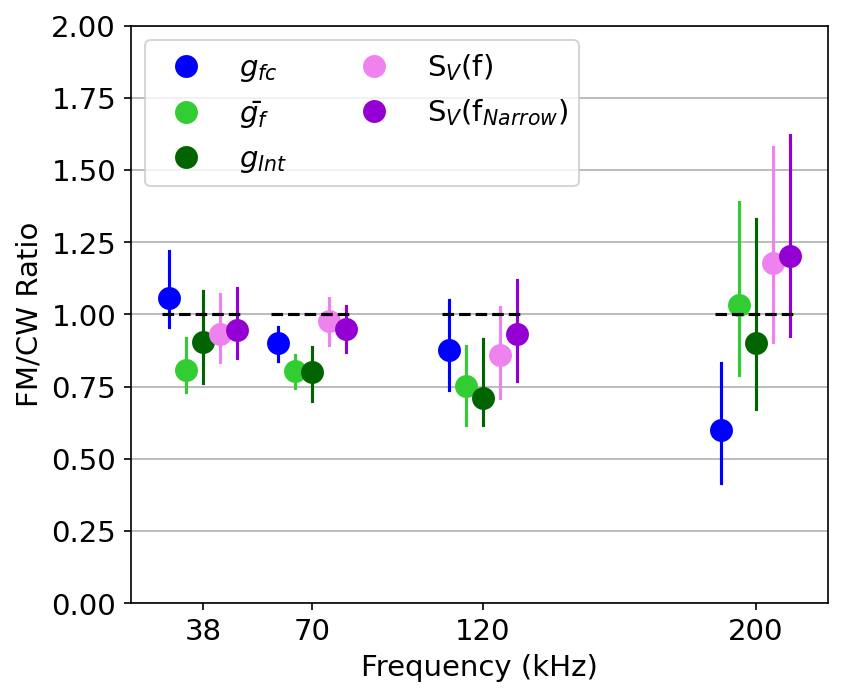

2023-11-28 11:03:59,605 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:04:12,675 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:04:27,062 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:04:42,522 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:04:54,895 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:05:07,999 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:05:18,509 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-11-28 11:05:30,352 - distributed.utils_perf - WARNING - full garbage collections took

In [41]:
# 15 min 
plt.figure(figsize=(6,5),dpi=150)
plt.rcParams.update({'font.size': 14})
colors = {'mean_Sv_fc':'b','mean_Sv_fave':'limegreen','mean_Sv_int':'darkgreen','mean_Sv_f':'violet','mean_Sv_f_bw':'darkviolet'}
frequencies = [38000,70000,120000,200000]
for f in frequencies:
    fp =f 
    for cal in ['mean_Sv_fc','mean_Sv_fave','mean_Sv_int','mean_Sv_f','mean_Sv_f_bw']:
        plt.plot(fp-10000,10**(np.nanmean(np.log10(ratios[(ratios.f==f)&(ratios.calType==cal)].r))),'.',color=colors[cal],markersize=20)
        #plt.plot(fp-10000,np.nanmedian(ratios[(ratios.f==f)&(ratios.calType==cal)].r),'x',color=colors[cal],markersize=20,label='_nolegend_')
        plt.plot([fp-10000,fp-10000],[np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,2.5), np.percentile(ratios[(ratios.f==f)&(ratios.calType==cal)].r,97.5)],color=colors[cal],markersize=20,label='_nolegend_')
        fp+=5000
    plt.hlines(1,f-12000,f+12000,'k',linestyle='--')
plt.ylim([0,2])
plt.xticks(frequencies,labels = [str(int(f/1000)) for f in frequencies])
plt.grid(axis='y')                                              
plt.legend(['$g_{fc}$',r'$\bar{g_{f}}$','$g_{Int}$','S$_{V}$(f)','S$_{V}$(f$_{Narrow}$)'],ncol=2)
plt.ylabel('FM/CW Ratio')
plt.xlabel('Frequency (kHz)')


In [20]:
d38 =  ddf_merge_all_snr[ddf_merge_all_snr.channel==38000]
d38['file_name'] = d38.file_name.apply(lambda x: x.split('_')[0])
d70 =  ddf_merge_all_snr[ddf_merge_all_snr.channel==70000]
d70['file_name'] = d70.file_name.apply(lambda x: x.split('_')[0])
d120 = ddf_merge_all_snr[ddf_merge_all_snr.channel==120000]
d120['file_name'] = d120.file_name.apply(lambda x: x.split('_')[0])
d200 =  ddf_merge_all_snr[ddf_merge_all_snr.channel==200000]
d200['file_name'] = d200.file_name.apply(lambda x: x.split('_')[0])

d = d38.merge(d120,on=['file_name','interval','layer'],suffixes=('_38','_120')) # merge everything on the filename, frequency, interval, and layer
d = d.merge(d70,on=['file_name','interval','layer'],suffixes=('','_70')) # merge everything on the filename, frequency, interval, and layer
e = d.merge(d200,on=['file_name','interval','layer'],suffixes=('','_200')) # merge everything on the filename, frequency, interval, and layer

C:\Users\robert.levine\AppData\Local\Temp\ipykernel_25744\625999143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d38['file_name'] = d38.file_name.apply(lambda x: x.split('_')[0])
C:\Users\robert.levine\AppData\Local\Temp\ipykernel_25744\625999143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d70['file_name'] = d70.file_name.apply(lambda x: x.split('_')[0])
C:\Users\robert.levine\AppData\Local\Temp\ipykernel_25744\625999143.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

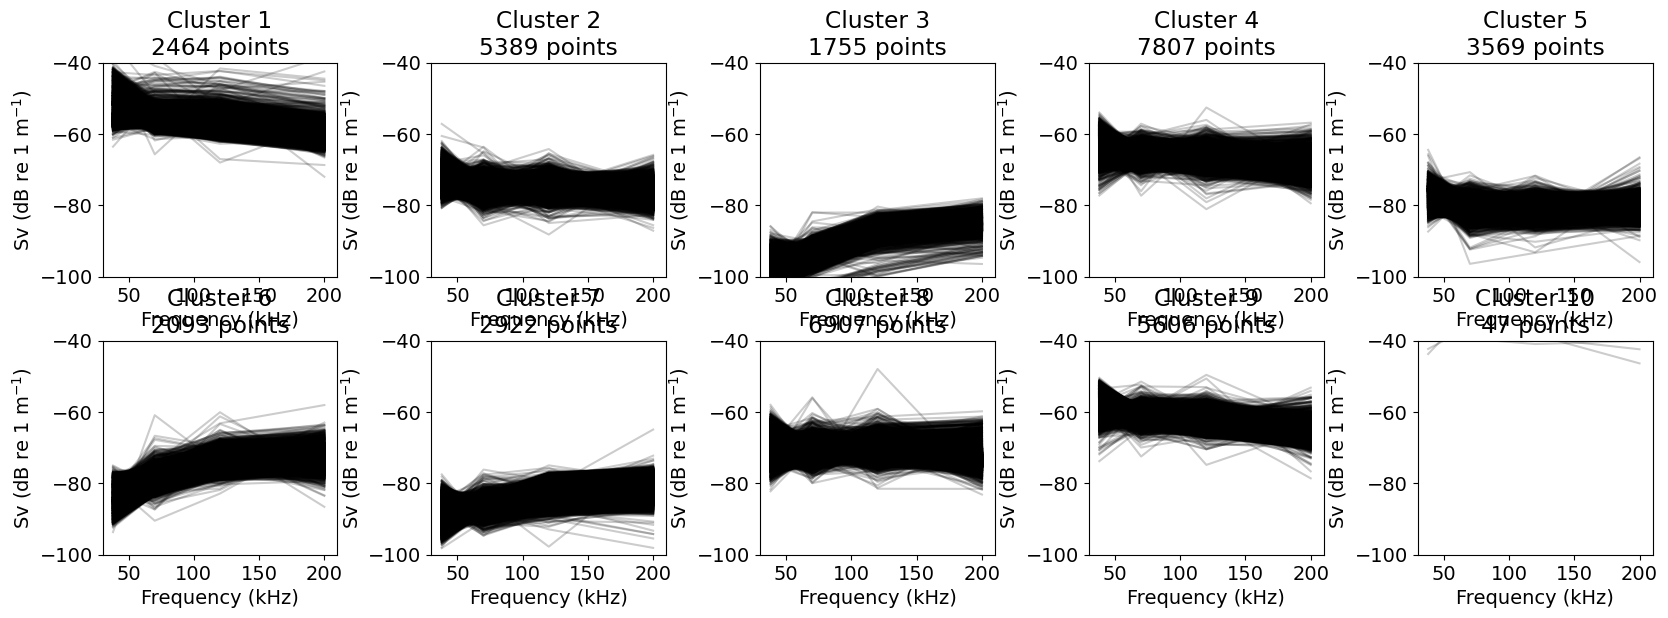

In [21]:
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm
cs = iter(cm.viridis(np.linspace(0, 1, 8)))

kmeans = KMeans(n_clusters=10)
y = kmeans.fit_predict(e[['mean_Sv_cw_38','mean_Sv_cw','mean_Sv_cw_120','mean_Sv_cw_200']])
e['cluster'] = y
plt.figure(figsize=(20,10))
for i in e.cluster.unique():
    plt.subplot(3,5,i+1)
    plt.plot([38,70,120,200],[e[e.cluster==i].mean_Sv_cw_38,e[e.cluster==i].mean_Sv_cw,e[e.cluster==i].mean_Sv_cw_120,e[e.cluster==i].mean_Sv_cw_200],color='k',alpha=0.2)
    plt.axis([30,210,-100,-40])
    plt.title('Cluster '+str(i+1)+'\n'+str(len(e[e.cluster==i]))+' points')
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Sv (dB re 1 m$^{-1}$)')

plt.subplots_adjust(hspace=0.3, wspace=0.4)


In [22]:
fish = e[e.cluster==8][['file_name','interval','layer','mean_Sv_cw_38','mean_Sv_cw','mean_Sv_cw_120','mean_Sv_cw_200']]
zoop = e[e.cluster==5][['file_name','interval','layer','mean_Sv_cw_38','mean_Sv_cw','mean_Sv_cw_120','mean_Sv_cw_200']]

(30.0, 265.0)

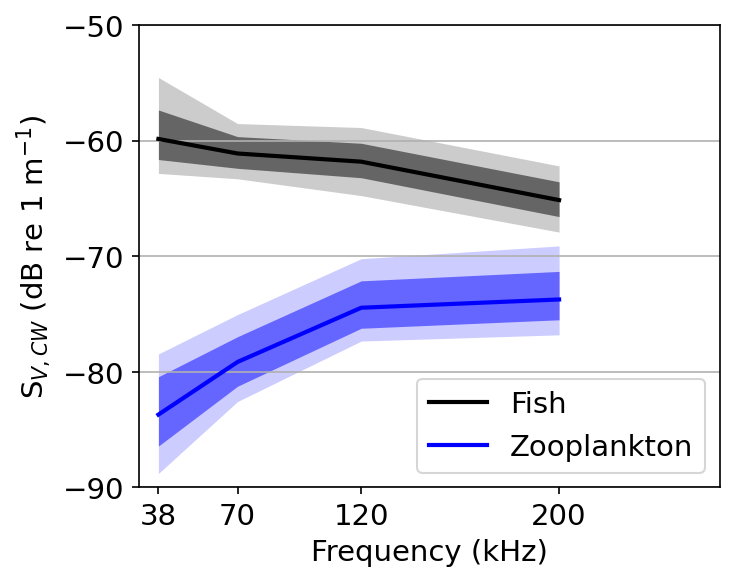

In [23]:
color = iter(['k','blue'])
low,high = 25,75
lowl,highh = 10,90

plt.figure(figsize=(5,4),dpi=150)
for d in [fish,zoop]:
    col = next(color)
    plt.plot([38,70,120,200],[np.median(d.mean_Sv_cw_38),np.median(d.mean_Sv_cw),np.median(d.mean_Sv_cw_120),np.median(d.mean_Sv_cw_200)],c=col,linewidth=2)
    plt.fill_between([38,70,120,200],[np.percentile(d.mean_Sv_cw_38,low), np.percentile(d.mean_Sv_cw,low),np.percentile(d.mean_Sv_cw_120,low),np.percentile(d.mean_Sv_cw_200,low)],
                        [np.percentile(d.mean_Sv_cw_38,high), np.percentile(d.mean_Sv_cw,high),np.percentile(d.mean_Sv_cw_120,high),np.percentile(d.mean_Sv_cw_200,high)],color=col,alpha=0.5,linewidth=0,label='_nolegend_')
    plt.fill_between([38,70,120,200],[np.percentile(d.mean_Sv_cw_38,lowl), np.percentile(d.mean_Sv_cw,lowl),np.percentile(d.mean_Sv_cw_120,lowl),np.percentile(d.mean_Sv_cw_200,lowl)],
                        [np.percentile(d.mean_Sv_cw_38,highh), np.percentile(d.mean_Sv_cw,highh),np.percentile(d.mean_Sv_cw_120,highh),np.percentile(d.mean_Sv_cw_200,highh)],color=col,alpha=0.2,linewidth=0,label='_nolegend_')

plt.grid(axis='y')
plt.xticks([38,70,120,200])
plt.xlabel('Frequency (kHz)')
plt.ylabel('S$_{V,CW}$ (dB re 1 m$^{-1}$)')
plt.legend(['Fish','Zooplankton'],loc='lower right',fontsize=14)
plt.ylim(-90,-50)
plt.xlim(30,265)

In [24]:
fishB = fish.join(e,lsuffix='',rsuffix='_')
fishB = fishB[fishB.filter(regex='mean_Sv').columns]
fishB.rename(columns={'mean_Sv_cw':'mean_Sv_cw_70','mean_Sv_int':'mean_Sv_int_70','mean_Sv_f':'mean_Sv_f_70'},inplace=True)

zoopB = zoop.join(e,lsuffix='',rsuffix='_')
zoopB = zoopB[zoopB.filter(regex='mean_Sv').columns]
zoopB.rename(columns={'mean_Sv_cw':'mean_Sv_cw_70','mean_Sv_int':'mean_Sv_int_70','mean_Sv_f':'mean_Sv_f_70'},inplace=True)

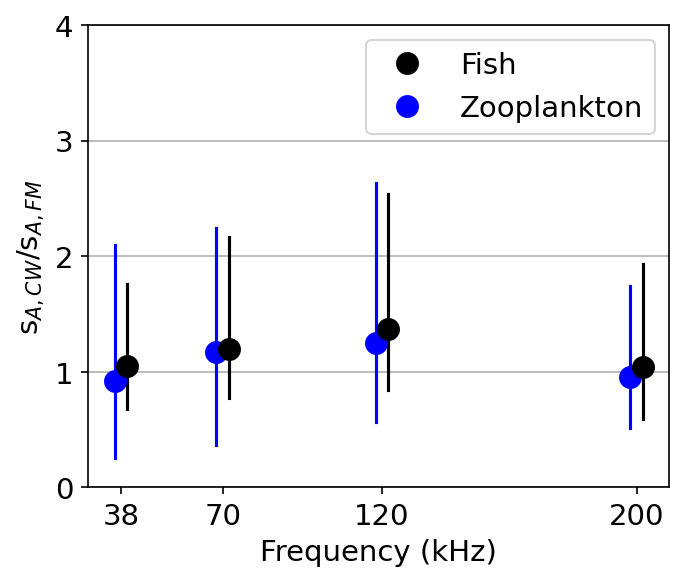

In [25]:
plt.figure(figsize=(5,4),dpi=150)

plt.subplot(1,1,1)
for f in ['38','70','120','200']:
    #color = iter(['gold','tomato','dodgerblue'])
    cur = ((10**(zoopB['mean_Sv_cw_'+f]/10))*5*4*np.pi*(1852**2))/((10**(zoopB['mean_Sv_int_'+f]/10))*5*4*np.pi*(1852**2))
    curf = ((10**(fishB['mean_Sv_cw_'+f]/10))*5*4*np.pi*(1852**2))/((10**(fishB['mean_Sv_int_'+f]/10))*5*4*np.pi*(1852**2))
    plt.plot(int(f)+2,np.median(curf),'o',color='k',markersize=10,zorder=5)
    plt.plot(np.array([int(f),int(f)])+2,[np.percentile(curf,2.5),np.percentile(curf,97.5)],color='k',label='_nolegend_')
    plt.plot(int(f)-2,np.median(cur),'o',color='b',markersize=10)
    plt.plot(np.array([int(f),int(f)])-2,[np.percentile(cur,2.5),np.percentile(cur,97.5)],color='b',label='_nolegend_')

plt.grid(axis='y')
plt.xticks([38,70,120,200])
plt.xlabel('Frequency (kHz)')
plt.ylabel('s$_{A,CW}$/s$_{A,FM}$')
plt.ylim([0,4])
#plt.title('$G_{Int}$')
plt.legend(['Fish','Zooplankton'],loc='upper right',fontsize=14)

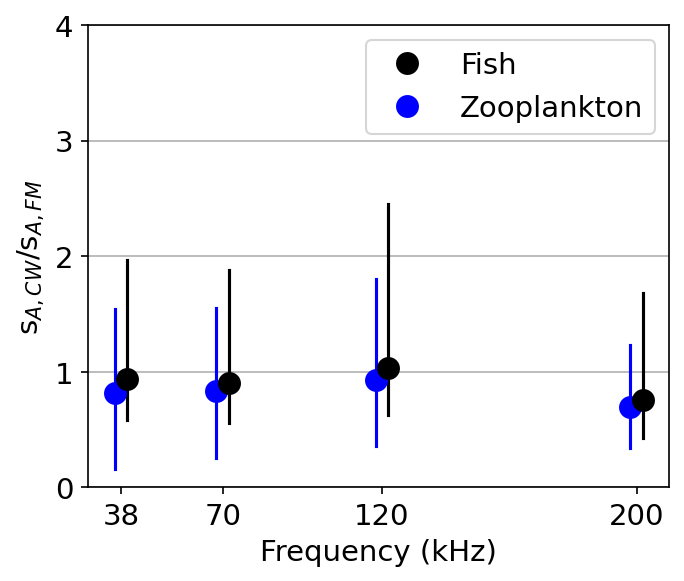

In [26]:
plt.figure(figsize=(5,4),dpi=150)

plt.subplot(1,1,1)
for f in ['38','70','120','200']:
    #color = iter(['gold','tomato','dodgerblue'])
    cur = ((10**(zoopB['mean_Sv_cw_'+f]/10))*5*4*np.pi*(1852**2))/((10**(zoopB['mean_Sv_f_'+f]/10))*5*4*np.pi*(1852**2))
    curf = ((10**(fishB['mean_Sv_cw_'+f]/10))*5*4*np.pi*(1852**2))/((10**(fishB['mean_Sv_f_'+f]/10))*5*4*np.pi*(1852**2))
    plt.plot(int(f)+2,np.median(curf),'o',color='k',markersize=10,zorder=5)
    plt.plot(np.array([int(f),int(f)])+2,[np.percentile(curf,2.5),np.percentile(curf,97.5)],color='k',label='_nolegend_')
    plt.plot(int(f)-2,np.median(cur),'o',color='b',markersize=10)
    plt.plot(np.array([int(f),int(f)])-2,[np.percentile(cur,2.5),np.percentile(cur,97.5)],color='b',label='_nolegend_')

plt.grid(axis='y')
plt.xticks([38,70,120,200])
plt.xlabel('Frequency (kHz)')
plt.ylabel('s$_{A,CW}$/s$_{A,FM}$')
plt.ylim([0,4])
#plt.title('$G_{Int}$')
plt.legend(['Fish','Zooplankton'],loc='upper right',fontsize=14)

In [27]:
ddf = dd.read_csv(output_dir+'svf/*.csv',include_path_column="file_path") # Read in svf output data
ddf = ddf.reset_index().compute()
ddf['frequency'] = ddf['frequency'].map(lambda x: np.array([float(i) for i in x.split(';')])) # convert strings to vectors
ddf['mean_Sv'] = ddf['mean_Sv'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['SNR'] = ddf['SNR'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['SNR_f'] = ddf['SNR'].map(svf.pMean) # Get the average SNR (this is the lazy way to do this for now)
ddf['file_name'] = ddf.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1]) # insert the file name just so I can hold it fo reference

d:\FMCW\svf\svf_buildAll.py:412: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))


In [28]:
dsv = ddf[['channel','interval','layer','file_name','frequency','mean_Sv','SNR']]
dsv['file_name'] = dsv.file_name.apply(lambda x: x.split('_')[0])

C:\Users\robert.levine\AppData\Local\Temp\ipykernel_25744\4108190174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsv['file_name'] = dsv.file_name.apply(lambda x: x.split('_')[0])


In [29]:
fname, intervals, layers, frequency, mean_Sv,snr = [], [], [], [], [],[]
for fn in dsv.file_name.unique():
    cur_dsv = dsv[dsv.file_name==fn]
    for interval in cur_dsv.interval.unique():
        cur_dsv2 = cur_dsv[cur_dsv.interval==interval]
        for layer in cur_dsv2.layer.unique():
            cur_dsv3 = cur_dsv2[cur_dsv2.layer==layer]
            if (np.isnan(np.concatenate(cur_dsv3.sort_values('channel').mean_Sv.values)).any())|(np.concatenate(cur_dsv3.SNR.values)<10).any()|(svf.pMean(np.concatenate(cur_dsv3.mean_Sv.values))>0):
                continue 
            else:
                mean_Sv.append(np.concatenate(cur_dsv3.sort_values('channel').mean_Sv.values))
                fname.append(fn)
                intervals.append(interval)
                layers.append(layer)
                frequency.append(np.concatenate(cur_dsv3.sort_values('channel').frequency.values))
                snr.append(np.concatenate(cur_dsv3.sort_values('channel').SNR.values))
            
dsv_new = pd.DataFrame({'file_name':fname,'interval':intervals,'layer':layers,'frequency':frequency,'mean_Sv':mean_Sv,'snr':snr})

d:\FMCW\svf\svf_buildAll.py:412: RuntimeWarning: Mean of empty slice
  return 10*np.log10(np.nanmean(10**(data/10),axis=axis))


In [30]:
fishF = fish.merge(dsv_new,on=['file_name','interval','layer'])
zoopF = zoop.merge(dsv_new,on=['file_name','interval','layer'])

(30.0, 265.0)

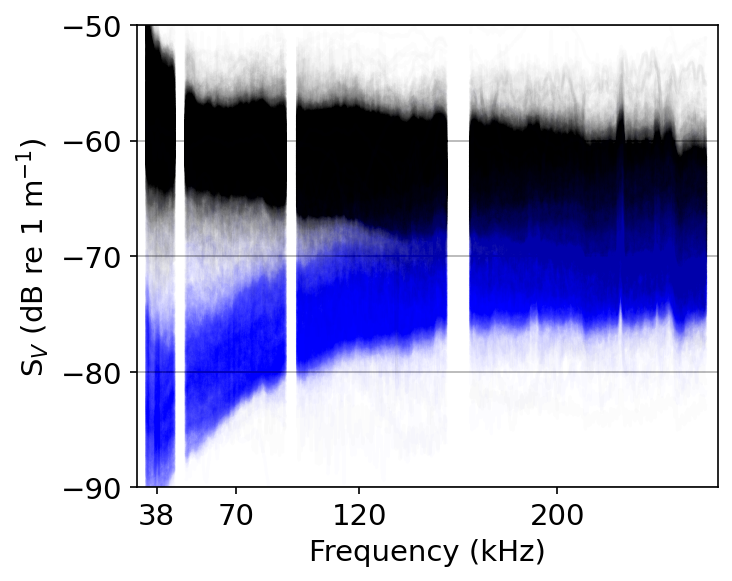

In [48]:
plt.figure(figsize=(5,4),dpi=150)
for f,sv,snr in zip(fishF.frequency,fishF.mean_Sv,fishF.snr):
    for fr in [[34000,45000],[50000,90000],[95000,155000],[165000,260000]]:
        plt.plot(f[(f>=fr[0])&(f<=fr[1])]/1000,sv[(f>=fr[0])&(f<=fr[1])],'-',color='k',alpha=0.01,markersize=2.5, markeredgecolor='none')



for z,svz,snr in zip(zoopF.frequency,zoopF.mean_Sv,zoopF.snr):
    for fr in [[34000,45000],[50000,90000],[95000,155000],[165000,260000]]:
        plt.plot(z[(z>=fr[0])&(z<=fr[1])]/1000,svz[(z>=fr[0])&(z<=fr[1])],'b',alpha=0.01,markersize=2.5, markeredgecolor='none')
#plt.plot(fishF.iloc[i].frequency,fishF.iloc[i].mean_Sv)

plt.grid(axis='y')
plt.xticks([38,70,120,200])
plt.xlabel('Frequency (kHz)')
plt.ylabel('S$_{V}$ (dB re 1 m$^{-1}$)')
#plt.legend(['Fish','Zooplankton'],loc='lower right',fontsize=14)
plt.ylim(-90,-50)
plt.xlim(30,265)

(30.0, 265.0)

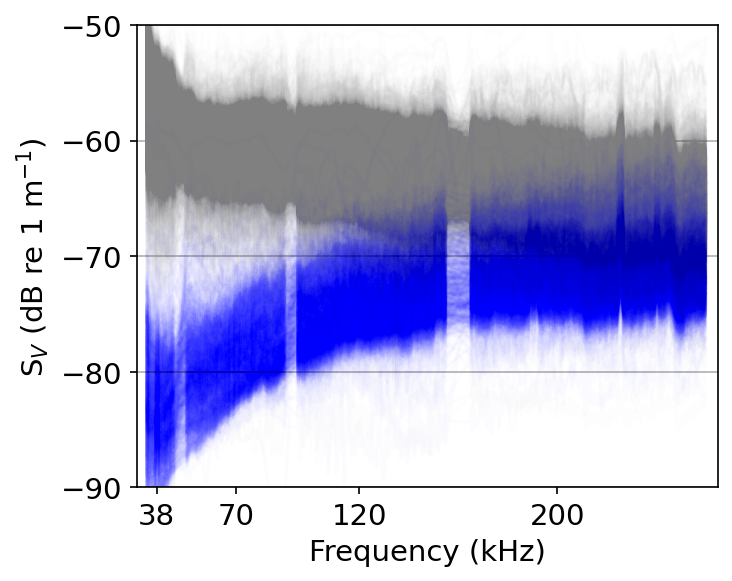

In [596]:
plt.figure(figsize=(5,4),dpi=150)
for f,sv,snr in zip(fishF.frequency,fishF.mean_Sv,fishF.snr):
    plt.plot(f/1000,sv,'-',color='grey',alpha=0.01,markersize=2.5, markeredgecolor='none')
    
for z,svz,snr in zip(zoopF.frequency,zoopF.mean_Sv,zoopF.snr):
    plt.plot(z/1000,svz,'b',alpha=0.01,markersize=2.5, markeredgecolor='none')
#plt.plot(fishF.iloc[i].frequency,fishF.iloc[i].mean_Sv)

plt.grid(axis='y')
plt.xticks([38,70,120,200])
plt.xlabel('Frequency (kHz)')
plt.ylabel('S$_{V}$ (dB re 1 m$^{-1}$)')
#plt.legend(['Fish','Zooplankton'],loc='lower right',fontsize=14)
plt.ylim(-90,-50)
plt.xlim(30,265)

In [63]:
# Example Echogram slivers
from glob import glob 
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram


fish = glob('E:/BB/202207_EBS/EK80/*D20220628*.raw')[60:62]
zoop = glob('E:/BB/202207_EBS/EK80/*D20220614*.raw')[8]

ek80 = EK80.EK80()
ek80.read_raw(zoop)

c:\Users\robert.levine\Anaconda3\lib\site-packages\pyecholab-0.0.2-py3.9.egg\echolab2\instruments\EK80.py:4313: RuntimeWarning: divide by zero encountered in log10
  tvg = 20.0 * np.log10(tvg)


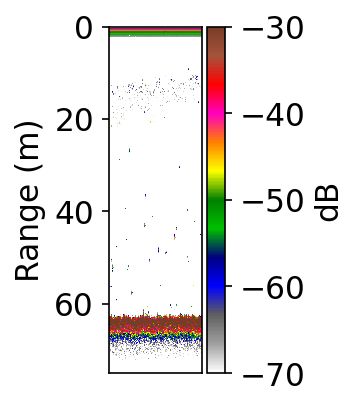

In [73]:
import matplotlib.colors as colors
test = colors.Colormap('viridis')
%matplotlib inline

f = 38000
d = ek80.get_channel_data(frequencies=f)[f][1]
d_sv = d.get_Sv()

fig_1 = figure(figsize=(1,3),dpi=150)
eg = echogram.Echogram(fig_1, d_sv,threshold=[-70,-30])
eg.axes.grid(False)
eg.axes.set_ylim(0,75)
eg.axes.invert_yaxis()
eg.axes.set_xticks([])
eg.axes.set_xlabel('')
eg.axes.set_ylabel('Range (m)')
eg.add_colorbar(fig=fig_1)
show()


Text(0.5, 0, 'Frequency (kHz)')

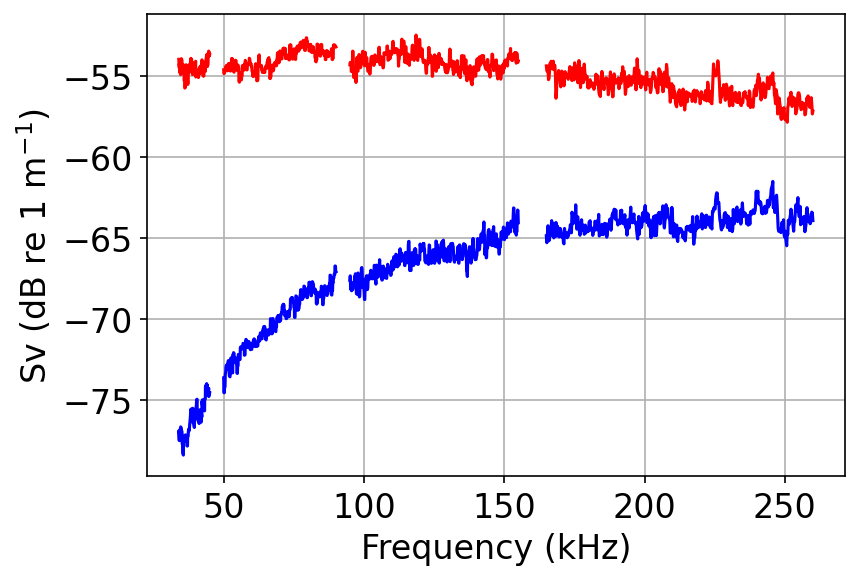

In [323]:
fig = plt.figure(figsize=(6,4),dpi=150)
plt.rcParams.update({'font.size': 16})
ddf = dd.read_csv(output_dir+'svf/*D20220614*.csv',include_path_column="file_path") # Read in svf output data
ddf = ddf.reset_index().compute()
ddf['frequency'] = ddf['frequency'].map(lambda x: np.array([float(i) for i in x.split(';')])) # convert strings to vectors
ddf['mean_Sv'] = ddf['mean_Sv'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['file_name'] = ddf.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1].split('_')[0]) # insert the file name just so I can hold it fo reference

for f,sv in zip(ddf[(ddf.file_name=='D20220614-T093428')&(ddf.layer==5)&(ddf.interval==1)].sort_values('channel').frequency,ddf[(ddf.file_name=='D20220614-T093428')&(ddf.layer==5)&(ddf.interval==1)].sort_values('channel').mean_Sv):
    plt.plot(f/1000,sv,color='b')

ddf = dd.read_csv(output_dir+'svf/*D20220628*.csv',include_path_column="file_path") # Read in svf output data
ddf = ddf.reset_index().compute()
ddf['frequency'] = ddf['frequency'].map(lambda x: np.array([float(i) for i in x.split(';')])) # convert strings to vectors
ddf['mean_Sv'] = ddf['mean_Sv'].map(lambda x: np.array([float(i) for i in x.split(';')]))# convert strings to vectors
ddf['file_name'] = ddf.file_path.apply(lambda x: x.split('\\')[-1].split('/')[-1].split('_')[0]) # insert the file name just so I can hold it fo reference

for f,sv in zip(ddf[(ddf.file_name=='D20220628-T151839')&(ddf.layer==17)&(ddf.interval==1)].sort_values('channel').frequency,ddf[(ddf.file_name=='D20220628-T151839')&(ddf.layer==17)&(ddf.interval==1)].sort_values('channel').mean_Sv):
    plt.plot(f/1000,sv,color='r')


plt.grid()
plt.ylabel('Sv (dB re 1 m$^{-1}$)')
plt.xlabel('Frequency (kHz)')

# Map from good data

In [1]:
from scipy.ndimage.filters import gaussian_filter
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
import numpy as np
%matplotlib inline
import cartopy.feature as cfeature
from matplotlib import cm

C:\Users\robert.levine\AppData\Local\Temp\ipykernel_13128\3005619815.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [118]:
etopo = xr.open_dataset('C:/Users/robert.levine/Work/projects/rltools/akMaps/PAR.nc')
lat = etopo.latitude
lon = etopo.longitude
topo = etopo.b_bathy[0,:,:]
rlons, rlats = np.meshgrid(lon, lat)

c:\Users\robert.levine\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
c:\Users\robert.levine\Anaconda3\lib\site-packages\xarray\coding\times.py:174: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
c:\Users\robert.levine\Anaconda3\lib\site-packages\xarray\coding\times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
c:\Users\robert.levine\Anaconda3\lib\site-packages\xarray\coding\times.py:174: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
c:\Users\robert.levine\Anaconda3\lib\site-packages

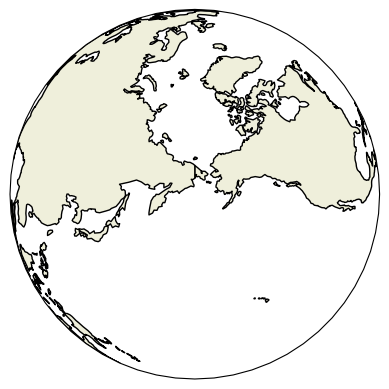

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(180, 60))

#ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

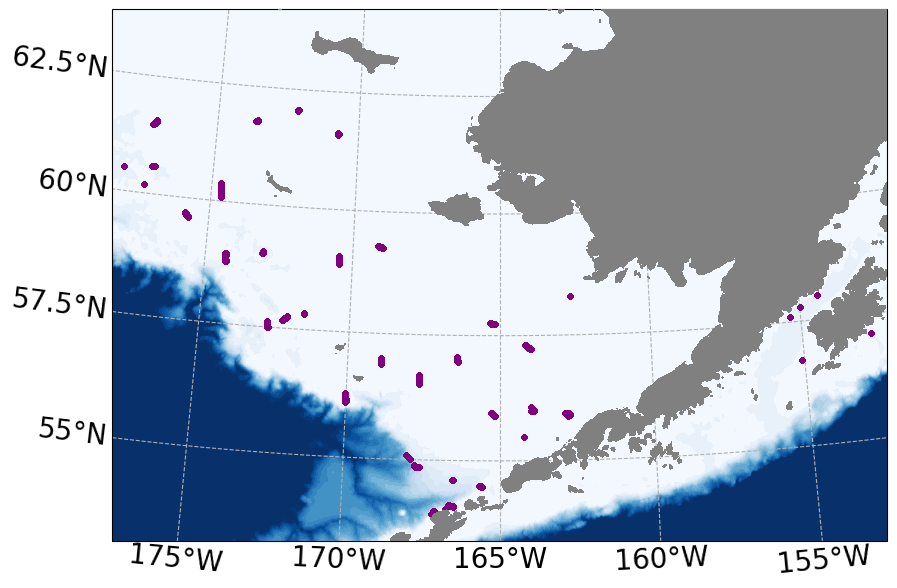

In [140]:
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size':20})
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-165))
ax.set_extent([-177, -153, 53,64])
#ax.add_feature(cartopy.feature.LAND,facecolor='grey',zorder=8)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linestyle='--',zorder=1)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -175, -170,-165,-160,-155,-150])
gl.ylocator = mticker.FixedLocator([52.5,55,57.5,60,62.5,65])

olevels1 = [-1000,-250,-100,-50]
olevels0 = [0,10000]

lfill = ax.contourf(rlons, rlats, topo, olevels0, colors ='grey',transform=ccrs.PlateCarree(),zorder=8)#cmap=cm.ocean)
#cso1 = ax.contour(rlons, rlats, topo, olevels1, linestyle='-',colors ='grey',transform=ccrs.PlateCarree(),zorder=2)#cmap=cm.ocean)

cc = cm.get_cmap('Blues_r', 512)
newcolors1 = cc(np.linspace(0, .5, 500))
newcolors2 = cc(np.linspace(.5, 1, 100))
all_colors = np.vstack((newcolors1, newcolors2))
terrain_map = mcolors.ListedColormap(all_colors)

plot = ax.contourf(lon, lat, topo, 100, cmap=cm.Blues_r,transform=ccrs.PlateCarree(),latlon=True,vmin=-3000, vmax=0,extend="both",zorder=0)


plt.plot(ddf_cw.lon_start, ddf_cw.lat_start,'.',color='purple',transform=ccrs.PlateCarree())

# Gain Plots

In [29]:
len(gall)

1

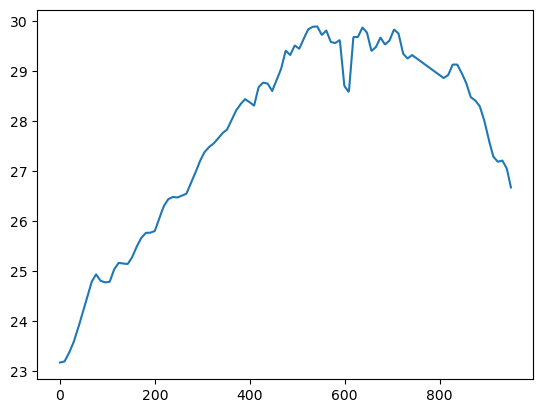

d:\FMCW\svf\gains.py:130: RuntimeWarning: Mean of empty slice
  df.loc[(df.cruise==cruise)&(df.leg==leg)&(df.f==f),'G_int_fm'] = 10*np.log10(np.nanmean(10**(curG/10)))


27.035948289343 [ 0.03659671 -0.0362909 ] 27.013911820910018 [ 0.13193639 -0.12804613] 0.023854975912763622
27.691823744180443 [ 0.04209597 -0.04169185] 27.721100904917012 [ 0.04407304 -0.04363026] -0.029259772226915004
26.56827802820534 [ 0.1248022  -0.12131574] 26.528129148998904 [ 0.16039487 -0.15468151] 0.041262657116145365
27.888279086506977 [ 0.12737097 -0.1237416 ] 28.365055850984213 [ 0.29642111 -0.27747555] -0.4690620451866373


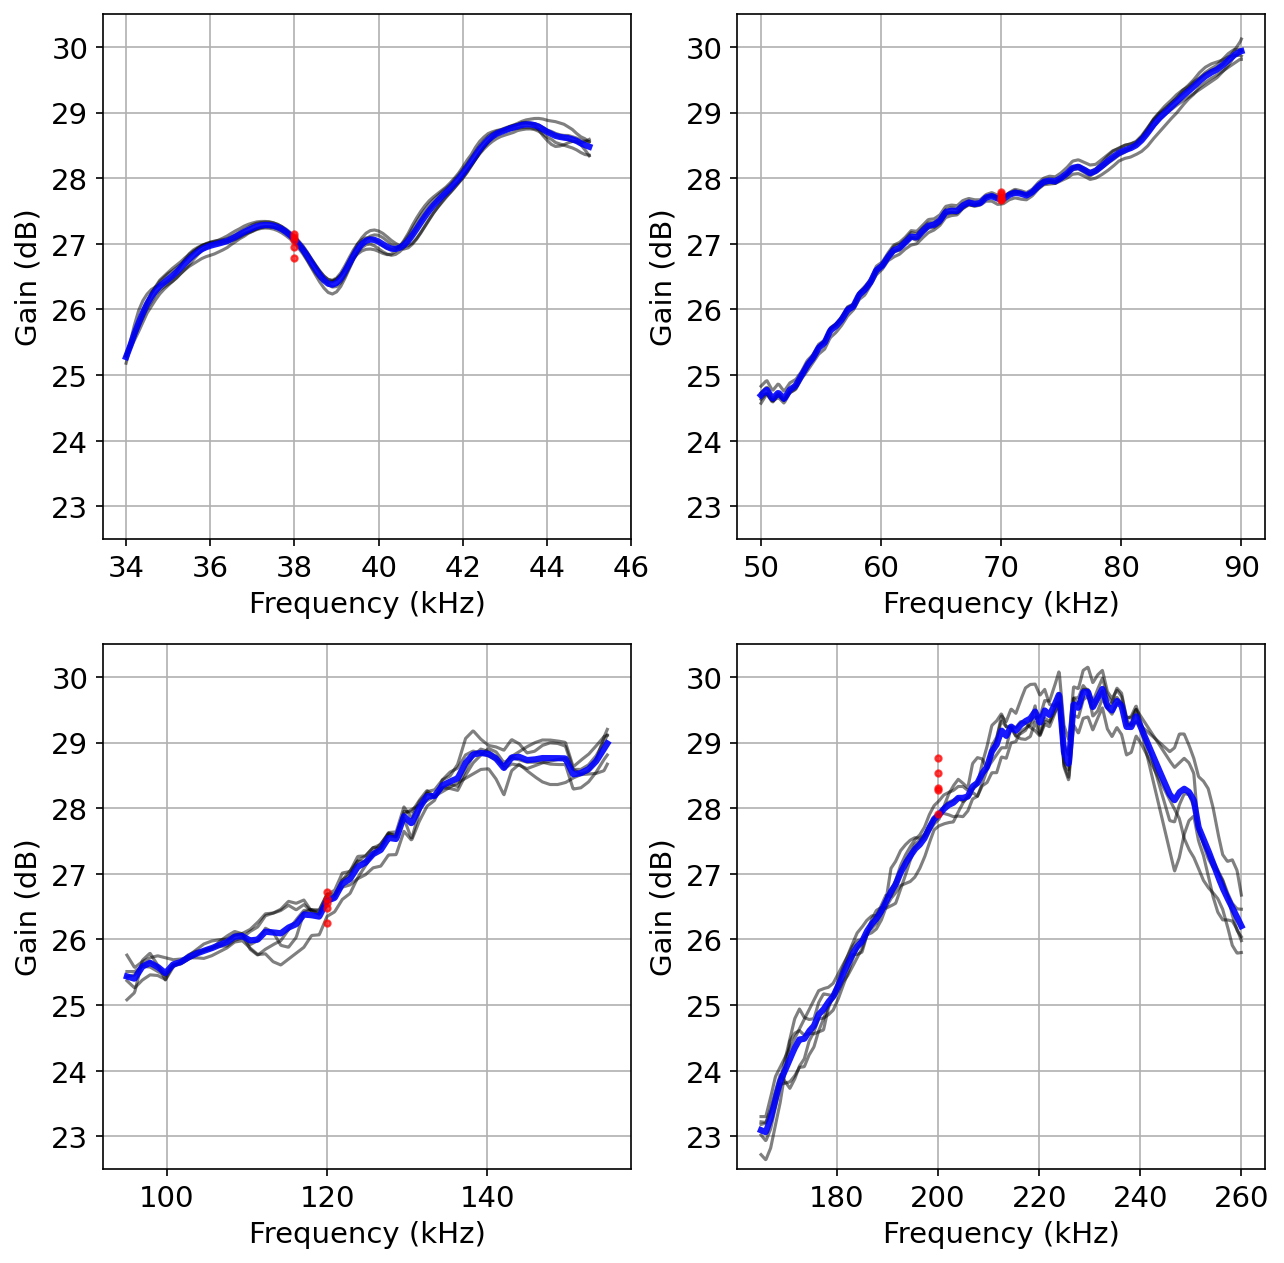

In [54]:
import gains
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
import svf as svf

# I'm lazy so I wanted a function for subsetting the smaller bandwidth section of the data. I need to turn this into a lookup with the real values
def sv_bw(g,f,z):
    return svf.pMean(g[np.where(np.abs(f-z)<(1000/2))])

gain = gains.gains()

plt.figure(figsize=(10,10),dpi=150)
ct = 1
for fr in [38,70,120,200]:
    gall = []
    plt.subplot(2,2,ct)
    cruises, legs = ['202200','202204','202207'],['L1','L2','L3']
    fmbw, cwbw = [],[]
    for cruise in cruises:
        for leg in legs:
            for pulse in ['FM']:
                
                if glob('E:/BB/WorkingProcessing/data/' + cruise +'/'+ leg+'/'+str(fr)+'*'+pulse+'*.xml'):
                    s,f,g1 = gain.calFM(glob('E:/BB/WorkingProcessing/data/' + cruise +'/'+ leg+'/'+str(fr)+'*'+pulse+'*.xml'),fr,full=True)
                    if s == 38:
                        plt.plot(f/1000,g1,color='k',alpha=0.5)
                    else:
                        plt.plot(f/1000,g1,color='k',linestyle='-',alpha=0.5)
                    gall.append(g1)

                if glob('E:/BB/WorkingProcessing/data/' + cruise +'/'+ leg+'/'+str(fr)+'*'+'CW'+'*.xml'):
                    s, g2 = gain.calCW(glob('E:/BB/WorkingProcessing/data/' + cruise +'/'+ leg+'/'+str(fr)+'*'+'CW'+'*.xml'))
                    
                    plt.plot(fr,g2,'.r',alpha=0.7,zorder=10)
                    if type(g2) == np.float64:
                        cwbw.append(g2)
                    else:
                        cwbw.append(g2[0])
                    fmbw.append(sv_bw(g1,f,fr*1000))
    plt.plot(f/1000,svf.pMean(np.array(gall)),color='blue',alpha = 0.9,linewidth=3)
    plt.grid()
    plt.ylabel('Gain (dB)')
    plt.xlabel('Frequency (kHz)')
    if fr ==38:
        plt.xticks([34,36,38,40,42,44,46])
    plt.ylim(22.5,30.5)
    ct+=1
                    

    print(svf.pMean(np.array(fmbw)),svf.pMean(np.array(fmbw))-svf.pStd(np.array(fmbw)),svf.pMean(np.array(cwbw)),svf.pMean(np.array(cwbw))-svf.pStd(np.array(cwbw)),np.mean(np.array(fmbw)-np.array(cwbw)))
                

In [4]:
gain.df

,cruise,leg,f,nfiles_FM,sphere_FM,G_fc_fm,G_fave_fm,nfiles_CW,sphere_CW,G_cw,G_int_fm
0,202200,L1,38,1,38,26.845253,27.487287,1,38,27.051000,27.316167
1,202200,L1,70,1,38,27.606258,27.707702,1,38,27.678200,27.440838
2,202200,L1,120,1,38,27.163913,27.166466,1,38,26.251800,27.258366
3,202200,L1,200,1,38,28.914811,27.721183,1,38,27.903900,27.997042
4,202204,L1,38,1,38,26.995556,27.500096,1,38,27.110300,27.080110
5,202204,L1,70,1,38,27.727484,27.817850,1,38,27.787100,27.714609
6,202204,L1,120,2,0,27.299806,27.461238,2,0,26.724246,27.308019
7,202204,L1,200,2,0,29.434564,27.868986,2,0,28.766619,27.818394
8,202207,L1,38,1,38,26.885556,27.429811,1,38,26.785200,27.180833
9,202207,L1,70,1,38,27.703742,27.787787,1,38,27.713400,27.676113


5
5
5
5


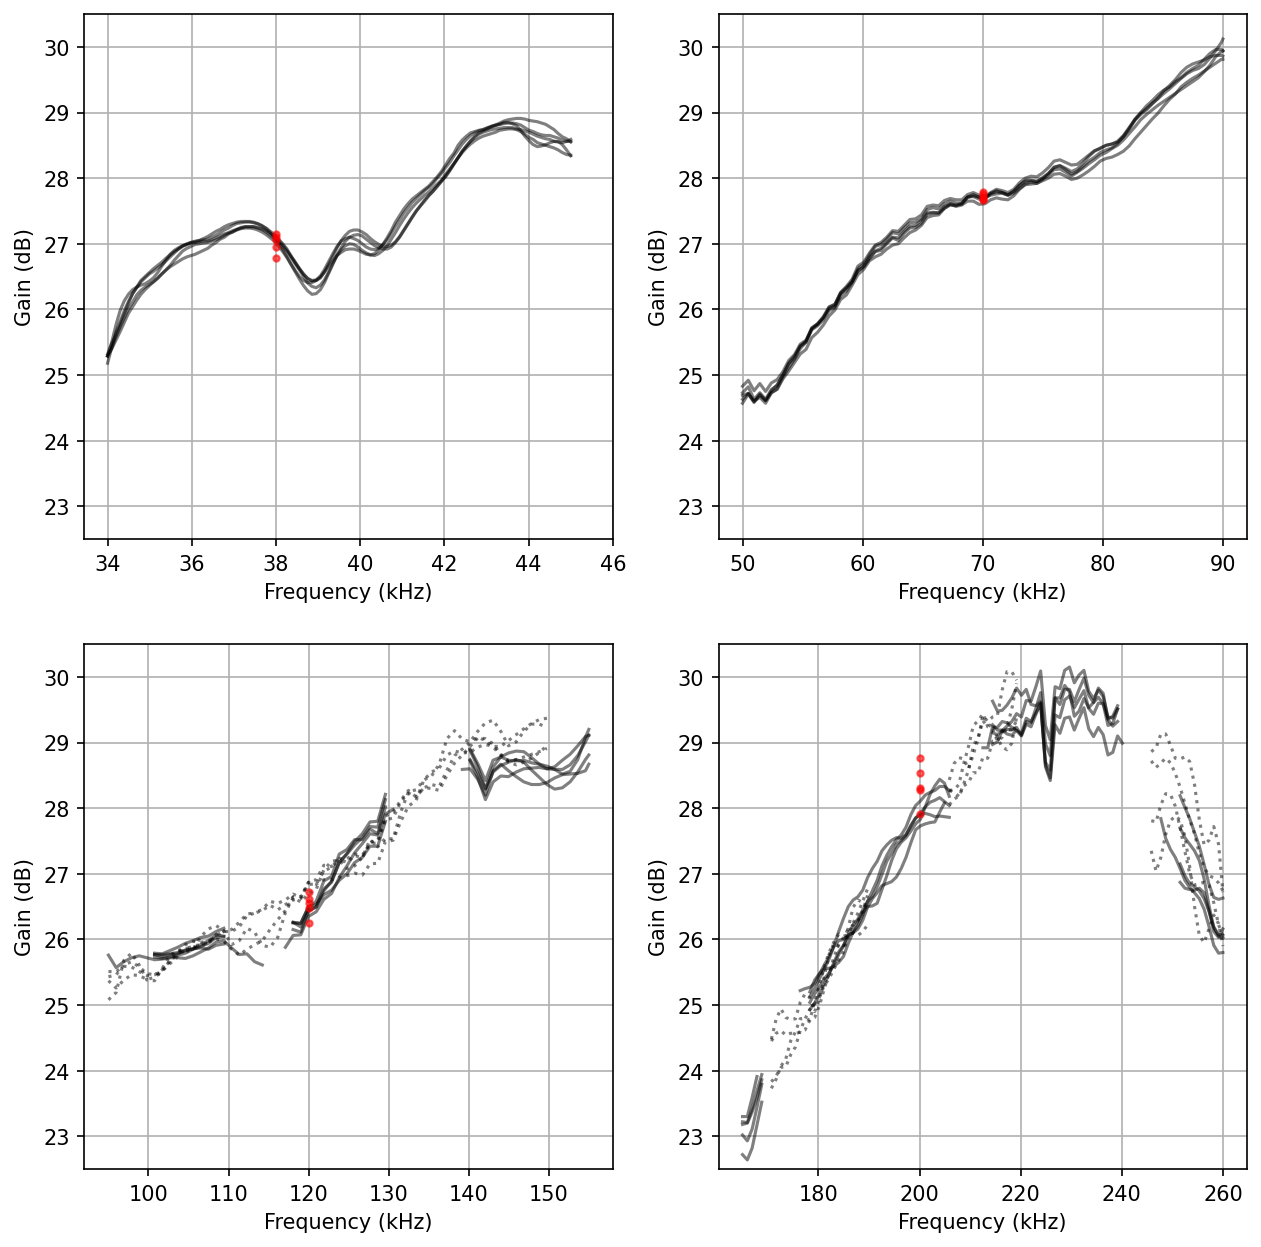

In [6]:
from glob import glob
import pandas as pd
df = gain.df
cs = {38:'k', 70:'k', 120:'k', 200:'k'}
cruises, legs, freqs = ['202200','202204','202207'],['L1','L2','L3'],[38,70,120,200]
plt.figure(figsize=(10,10),dpi=150)
for f in freqs:
    ax = plt.subplot(2,2,freqs.index(f)+1)
    plt.plot([f]*len(df[df.f==f].G_cw.values),df[df.f==f].G_cw.values,'.r',alpha=0.6,zorder=10)
    print(len(df[df.f==f].G_cw.values))
#    for v in df[df.f==f].G_cw.values:
#        plt.plot([f-.5,f+.5],[v,v],'r',alpha=0.6,zorder=10)
    for cruise in cruises:
        for leg in legs:
            for pulse in ['FM']:
                files = glob('E:/BB/WorkingProcessing/data/' + cruise +'/'+ leg+'/'+str(f)+'*'+pulse+'*.xml')
                for file in files:
                    calResults = pd.read_xml(file,xpath=".//CalibrationResults")
                    calF, calG = np.array([float(f) for f in calResults.Frequency.values[0].split(';')]), np.array([float(f) for f in calResults.Gain.values[0].split(';')])
                    startcalF = 0
                    calFlist,calGlist = [],[]
                    for k in range(len(calF)-1):
                        if calF[k+1]-calF[k] >1000:
                            calFlist.append(calF[startcalF:k+1])
                            calGlist.append(calG[startcalF:k+1])
                            startcalF = k+1
                        elif k == len(calF)-2:
                            calFlist.append(calF[startcalF:])
                            calGlist.append(calG[startcalF:])
                    for fr,g in zip(calFlist,calGlist):
                        if file[-6:-4]=='22':
                            ax.plot(fr/1000,g,':',color=cs[f],alpha=0.5)
                        else:
                            ax.plot(fr/1000,g,'-',color=cs[f],alpha=0.5)
                    ax.grid()
                    ax.set_ylabel('Gain (dB)')
                    ax.set_xlabel('Frequency (kHz)')
                    if f ==38:
                        plt.xticks([34,36,38,40,42,44,46])
                    plt.ylim(22.5,30.5)

In [52]:
df[df.f==120]

,cruise,leg,f,nfiles_FM,sphere_FM,G_fc_fm,G_fave_fm,nfiles_CW,sphere_CW,G_cw,G_int_fm
2,202200,L1,120,1,38,27.163913,27.166466,1,38,26.251800,27.258366
6,202204,L1,120,2,0,27.299806,27.461238,2,0,26.724246,27.308019
10,202207,L1,120,2,0,27.297817,27.428107,2,0,26.557950,27.342042
14,202207,L2,120,2,0,27.008236,27.442918,2,0,26.618156,27.338343
18,202207,L3,120,2,0,27.211495,27.500277,2,0,26.474013,27.673032


(26.0, 30.0)

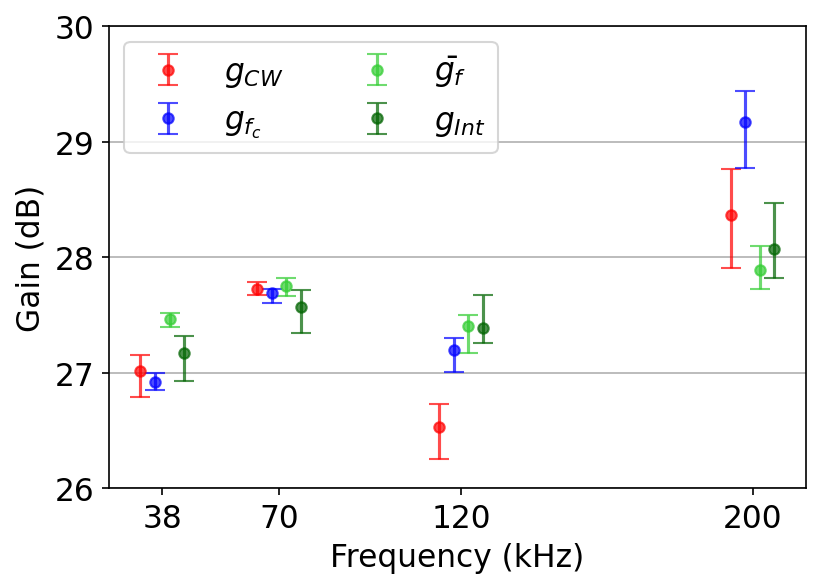

In [50]:
fig = plt.figure(figsize=(6,4),dpi=150)
freqs = [38,70,120,200]
plt.rcParams.update({'font.size': 15})

means,mins,maxs = [],[],[]
for f in freqs:
    means.append(10*np.log10(np.nanmean(10**(df[(df.f==f)].G_cw/10))))
    mins.append(np.nanmin(df[(df.f==f)].G_cw) )
    maxs.append(np.nanmax(df[(df.f==f)].G_cw) )
plt.errorbar(np.array(freqs)-6,means,yerr=[np.array(means)-np.array(mins),np.array(maxs)-np.array(means)],capsize=5,color='r',marker='.',markersize=10,alpha=0.7,linestyle='')

means,mins,maxs = [],[],[]
for f in freqs:
    means.append(10*np.log10(np.nanmean(10**(df[(df.f==f)].G_fc_fm/10))))
    mins.append(np.nanmin(df[(df.f==f)].G_fc_fm) )
    maxs.append(np.nanmax(df[(df.f==f)].G_fc_fm) )
plt.errorbar(np.array(freqs)-2,means,yerr=[np.array(means)-np.array(mins),np.array(maxs)-np.array(means)],capsize=5,color='b',marker='.',markersize=10,alpha=0.7,linestyle='')
means,mins,maxs = [],[],[]

for f in freqs:
    means.append(10*np.log10(np.nanmean(10**(df[(df.f==f)].G_fave_fm/10))))
    mins.append(np.nanmin(df[(df.f==f)].G_fave_fm) )
    maxs.append(np.nanmax(df[(df.f==f)].G_fave_fm) )
plt.errorbar(np.array(freqs)+2,means,yerr=[np.array(means)-np.array(mins),np.array(maxs)-np.array(means)],capsize=5,color='limegreen',marker='.',markersize=10,alpha=0.7,linestyle='')

means,mins,maxs = [],[],[]
for f in freqs:
    means.append(10*np.log10(np.nanmean(10**(df[(df.f==f)].G_int_fm/10))))
    mins.append(np.nanmin(df[(df.f==f)].G_int_fm) )
    maxs.append(np.nanmax(df[(df.f==f)].G_int_fm) )
plt.errorbar(np.array(freqs)+6,means,yerr=[np.array(means)-np.array(mins),np.array(maxs)-np.array(means)],capsize=5,color='darkgreen',marker='.',markersize=10,alpha=0.7,linestyle='')


plt.xticks([38,70,120,200])
plt.grid(axis='y')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Gain (dB)')
plt.ylim(26,29.5)
plt.legend(['$g_{CW}$','$g_{f_{c}}$',r'$\bar{g_{f}}$','$g_{Int}$'],ncol=2)
plt.ylim(26,30)